In [15]:
import numpy as np
import matplotlib.pyplot as plt
# custom package
import plotting_tools as pt
%matplotlib inline

import itertools

from matplotlib.patches import Ellipse
from scipy.stats import norm
from scipy import stats

# this is a module I created
from cluster_methods import *

from sklearn import decomposition
import skfuzzy as fuzz
from sklearn import preprocessing
from sklearn import manifold

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)

import kcorrect

from scipy import linalg

import cluster_methods
from sklearn.mixture import GMM
    
# exploring the properties of galaxies through multidimensional statistical analysis techniques 
# vespa data, galaxy zoo data, sdss
# this notebook is looking at how the final selection compares to the MGS in each band pass
# 0 sdss.modelMag_u, 
# 1 sdss.modelMag_r, 
# 2 sdss.petroMag_r, 
# 3 spec.z, 
# 4 sdss.petroR50_r, 
# 5 galex.fuv_mag, 
# 6 galex.nuv_mag, 
# 7 sdss.modelMag_u, 
# 8 sdss.modelMag_g,
# 9 sdss.modelMag_r,
# 10 sdss.modelMag_i,
# 11 sdss.modelMag_z
# 12 ukidss.yPetroMag, 
# 13 ukidss.j_1PetroMag,
# 14 ukidss.hPetroMag,
# 15 ukidss.kPetroMag,
# 16 wise.w1mpro ,  
# 17 wise.w2mpro , 
# 18 wise.w3mpro , 
# 19 wise.w4mpro , 
# 20 galex.fuv_magerr,
# 21 galex.nuv_magerr,
# 22 sdss.modelMagErr_u ,
# 23 sdss.modelMagErr_g , 
# 24 sdss.modelMagErr_r,
# 25 sdss.modelMagErr_i, 
# 26 sdss.modelMagErr_z,
# 27 ukidss.yPetroMagErr, 
# 28 ukidss.j_1PetroMagErr, 
# 29 ukidss.hPetroMagErr, 
# 30 ukidss.kPetroMagErr, 
# 31 wise.w1sigmpro, 
# 32 wise.w2sigmpro, 
# 33 wise.w3sigmpro, 
# 34 wise.w4sigmpro
# 0: stellar mass
# 1: error
# 2: SFR last 115 Myr
# 3: dustVal ISM
# 4: metallicity
# 5: redshift
# 6: prob. elliptical
# 7: prob. spiral
# 8: prob. merger
# 9: u
# 10: g
# 11: r
# 12: i
# 13: z
# 14: u err
# 15: g err
# 16: r err
# 17: i err
# 18: z err
# 19: petro r
# 20: theta
# 21: specObjID

# correct photometry, get blue cloud, save array 


def kernel_density_estimation(x,y):
    xmin = np.min(x)
    xmax = np.max(x)
    ymin = np.min(y)
    ymax = np.max(y)
    # Peform the kernel density estimate
    xx, yy = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    return xx,yy,f

In [16]:
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)

In [17]:
galaxies = np.load('/home/calum/Documents/Mphys_data/cat_check/all_vespa_properties.npy')
galaxies.shape

(51096, 56)

In [18]:
# load filters before hand - too slow to (and pointless) to load each time

def perform_kcorrect(redshift,magnitudes,mag_ivars):
    # remember to apply AB magnitude offsets
    maggies = pow(10,-0.4*np.array(magnitudes))
    maggies_ivar = pow(0.4*np.log(10)*maggies*np.array(mag_ivars),-2)
    c = kcorrect.fit_nonneg(redshift,maggies,maggies_ivar)
    rm = kcorrect.reconstruct_maggies(c)
    rm0 = kcorrect.reconstruct_maggies(c,redshift=0.)
    #print(magnitudes)
    #print(-2.5*np.log10(rm[1:]),-2.5*np.log10(rm0[1:]))
    #print(-2.5*np.log10(rm[1:]/rm0[1:]))
    return -2.5*np.log10(rm[1:]/rm0[1:]) 

def DM(z):
    return 5*(np.log10(cosmo.luminosity_distance(z).to(u.pc).value/10))

In [19]:
# galex-sdss
gkcorrections = []

kcorrect.load_templates()
kcorrect.load_filters(f='galex_sdss.dat')

for row in galaxies:
    # calculate kcorrections
    ktuple = perform_kcorrect(row[3],row[5:12],row[20:27])
    # store in array
    gkcorrections.append([row[3],ktuple])

/home/calum/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in power


In [20]:
# galexNUV-sdss
nuvkcorrections = []

kcorrect.load_templates()
kcorrect.load_filters(f='galex_nuv_sdss.dat')

for row in galaxies:
    # calculate kcorrections
    ktuple = perform_kcorrect(row[3],row[6:12],row[21:27])
    # store in array
    nuvkcorrections.append([row[3],ktuple])

/home/calum/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in power


In [21]:
# sdss
skcorrections = []

kcorrect.load_templates()
kcorrect.load_filters()

for row in galaxies:
    # calculate kcorrections
    ktuple = perform_kcorrect(row[3],row[7:12],row[22:27])
    # store in array
    skcorrections.append([row[3],ktuple])

In [22]:
# sdss-ukidss
ukcorrections = []

kcorrect.load_templates()
kcorrect.load_filters(f='sdss_ukidss.dat')

for row in galaxies:
    # calculate kcorrections
    ktuple = perform_kcorrect(row[3],row[7:16],row[22:31])
    # store in array
    ukcorrections.append([row[3],ktuple])

/home/calum/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in power


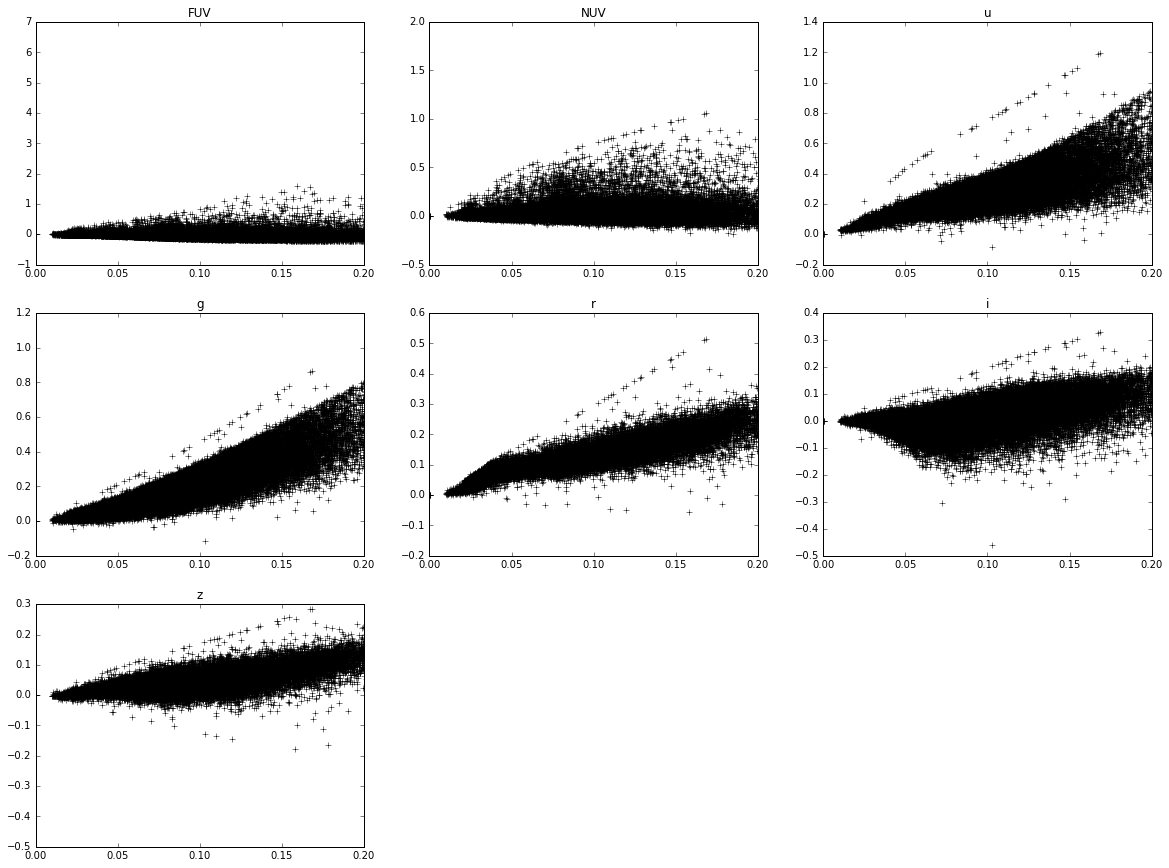

In [23]:
bands = ['FUV','NUV','u','g','r','i','z','Y','J','H','K','W1','W2']
plt.figure(figsize=(20,20))
for i,band in enumerate(bands[:-6]):
    plt.subplot(4,3,i+1)
    plt.plot([row[0] for row in gkcorrections],[row[1][i] for row in gkcorrections],'k+')
    plt.title(band)
    plt.xlim(0,0.2)

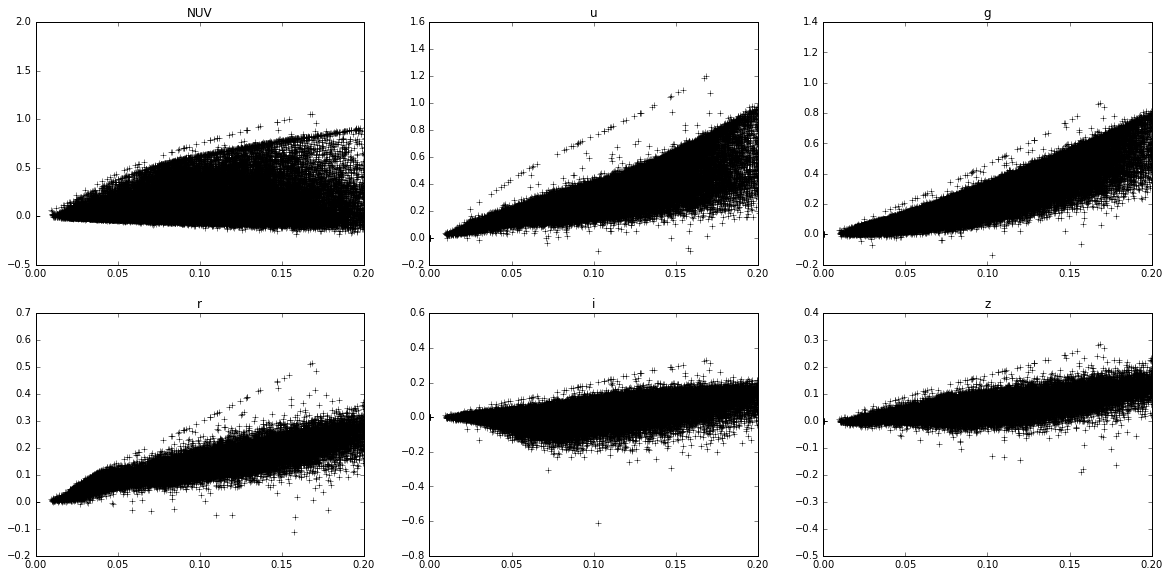

In [24]:
bands = ['FUV','NUV','u','g','r','i','z','Y','J','H','K','W1','W2']
plt.figure(figsize=(20,20))
for i,band in enumerate(bands[1:-6]):
    plt.subplot(4,3,i+1)
    plt.plot([row[0] for row in nuvkcorrections],[row[1][i] for row in nuvkcorrections],'k+')
    plt.title(band)
    plt.xlim(0,0.2)

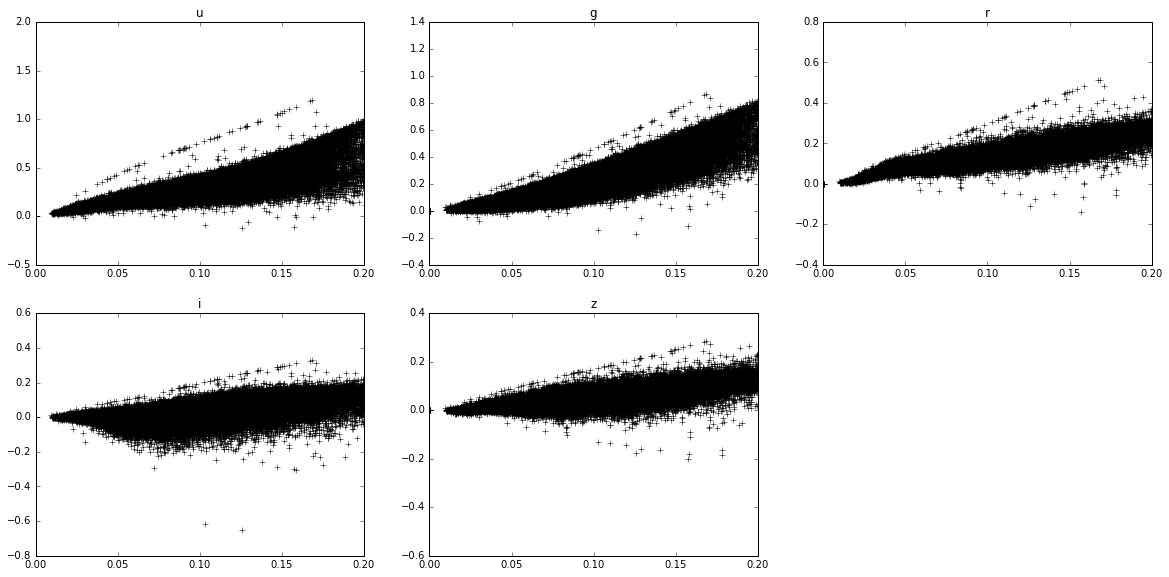

In [25]:
bands = ['FUV','NUV','u','g','r','i','z','Y','J','H','K','W1','W2']
plt.figure(figsize=(20,20))
for i,band in enumerate(bands[2:-6]):
    plt.subplot(4,3,i+1)
    plt.plot([row[0] for row in skcorrections],[row[1][i] for row in skcorrections],'k+')
    plt.title(band)
    plt.xlim(0,0.2)

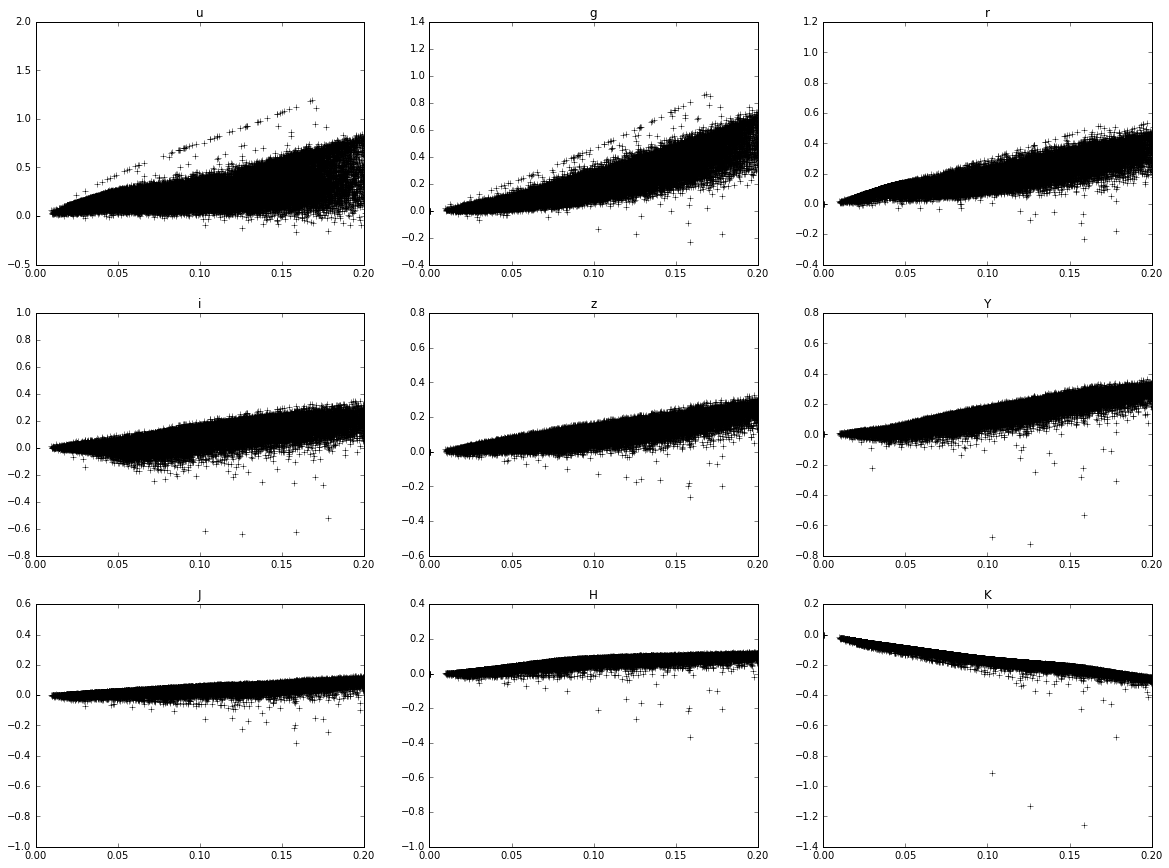

In [26]:
bands = ['FUV','NUV','u','g','r','i','z','Y','J','H','K','W1','W2']
plt.figure(figsize=(20,20))
for i,band in enumerate(bands[2:-2]):
    plt.subplot(4,3,i+1)
    plt.plot([row[0] for row in ukcorrections],[row[1][i] for row in ukcorrections],'k+')
    plt.title(band)
    plt.xlim(0,0.2)

In [27]:
len(ukcorrections),len(gkcorrections)

(51096, 51096)

In [28]:
# calculate absolute magnitudes for each band
M_galaxies = []
# M = m-DM(z)-K(z)
for i,galaxy in enumerate(galaxies):
    M = []
    M.append(galaxy[3])
    for magidx,magnitude in enumerate(galaxy[5:18]):
        # calculate absolute magnitude
        #print(bands[magidx])
        if magidx < 1:
            M.append(galaxy[magidx+5]-DM(galaxy[3])-gkcorrections[i][1][magidx])
        elif magidx < 2:
            M.append(galaxy[magidx+5]-DM(galaxy[3])-nuvkcorrections[i][1][magidx-1])
        elif magidx < 7:
            M.append(galaxy[magidx+5]-DM(galaxy[3])-skcorrections[i][1][magidx-2])            
        elif magidx < 11:
            M.append(galaxy[magidx+5]-DM(galaxy[3])-ukcorrections[i][1][magidx-7]) 
        else:
            M.append(galaxy[magidx+5]-DM(galaxy[3]))
            
    M_galaxies.append(M)   

/home/calum/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in log10


In [29]:
galaxies.shape, len(M_galaxies)

(51096, 56)

In [53]:
# 0 spec.z, 
# 1 galex.fuv_mag, 
# 2 galex.nuv_mag, 
# 3 sdss.modelMag_u, 
# 4 sdss.modelMag_g,
# 5 sdss.modelMag_r,
# 6 sdss.modelMag_i,
# 7 sdss.modelMag_z
# 8 ukidss.yPetroMag, 
# 9 ukidss.j_1PetroMag,
# 10 ukidss.hPetroMag,
# 11 ukidss.kPetroMag,
# 12 wise.w1mpro ,  
# 13 wise.w2mpro , 
np.save('/home/calum/Documents/Mphys_data/vespa_data/Mgalaxies.npy',M_galaxies)
M_galaxies = np.load('/home/calum/Documents/Mphys_data/vespa_data/Mgalaxies.npy')
len(M_galaxies), len([row for row in M_galaxies if 0.08>row[0]>0.004])

(51096, 17414)

In [31]:
# peform cluster analysis
rlim_galaxies = [row for row in galaxies if 0.08>row[3]>0.004 ]
rlim_Mgalaxies = [row for row in M_galaxies if 0.08>row[0]>0.004]
len(rlim_galaxies),len(rlim_Mgalaxies)

(17414, 17414)

In [32]:
# define dataset
data = []

# [row[0],row[1],row[6],row[7],row[10]

#create dataset for clustering
for i,row in enumerate(rlim_galaxies):
    # absolute r-band petrosian magnitude
    x0 = rlim_Mgalaxies[i][5]
    # k-corrected (u-r) colour
    x1 = rlim_Mgalaxies[i][3]-rlim_Mgalaxies[i][5]
    # redshift
    x2 = row[4]
    # morphological parameters
    x3 = 0
    x4 = 0
    x5 = 0
    if row[6] > 0.8:
        x3 = 1            
    if row[7] > 0.8:
        x4 = 1
    if row[8] > 0.8:
        x5 = 1
    # ISM dust value
    x6 = row[3]
    # log(stellar mass)
    x7 = np.log(row[0])
    # SFR last 115 Myr
    x8 = row[2]
    # metallicity average in last 5 age bins (115 Myr)
    x9 = row[4]
    # surface brightness
    x10 = row[19]+2.5*np.log10(2*np.pi*row[20]*row[20])
        
    # append to data
    data.append([x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10])

In [33]:
data = np.array(data)
data.shape

(17414, 11)

In [34]:
reduced_rlim_Mgalaxies = [row for row in rlim_Mgalaxies if False == np.isnan(row[5]) and row[3]-row[5]<4]
reduced_data = [row for row in data if False == np.isnan(row[0]) and row[1] < 4 ]
len(reduced_rlim_Mgalaxies), len(reduced_data)

(17334, 17334)

In [35]:
data = reduced_data
len(data)

17334

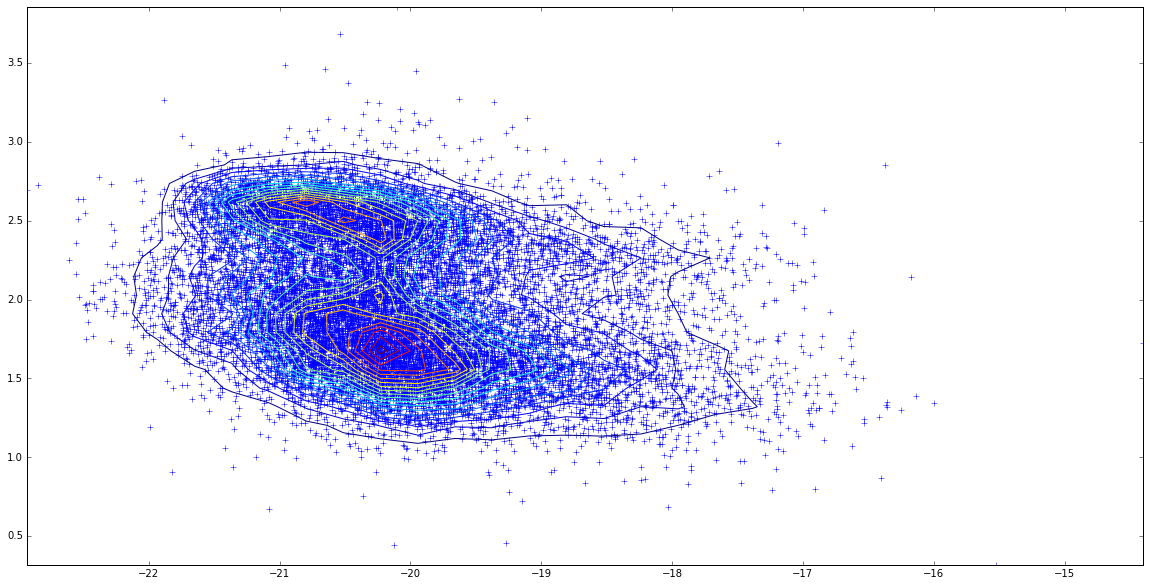

In [36]:
plt.figure(figsize=(20,10))
pt.plot_contour([row[0] for row in data],[row[1] for row in data],bins=30)
plt.plot([row[0] for row in data],[row[1] for row in data],'+')

In [37]:
# scale data before manifold learning
# select rows that will be used for clustering
data_clustering = [ [row[0],row[1],row[3],row[4],row[5],row[6],row[7],row[10]] for row in data]
data_scaled = preprocessing.scale(data_clustering)

In [38]:
#np.save('/home/calum/Documents/Mphys_data/vespa_data/mdata.npy',data)
#np.save('/home/calum/Documents/Mphys_data/vespa_data/scaledmdata.npy',data_scaled)
data = np.load('/home/calum/Documents/Mphys_data/vespa_data/mdata.npy')
data_scaled = np.load('/home/calum/Documents/Mphys_data/vespa_data/scaledmdata.npy')

/home/calum/anaconda3/lib/python3.5/site-packages/matplotlib/transforms.py:1965: ComplexWarning: Casting complex values to real discards the imaginary part
  np.float_)


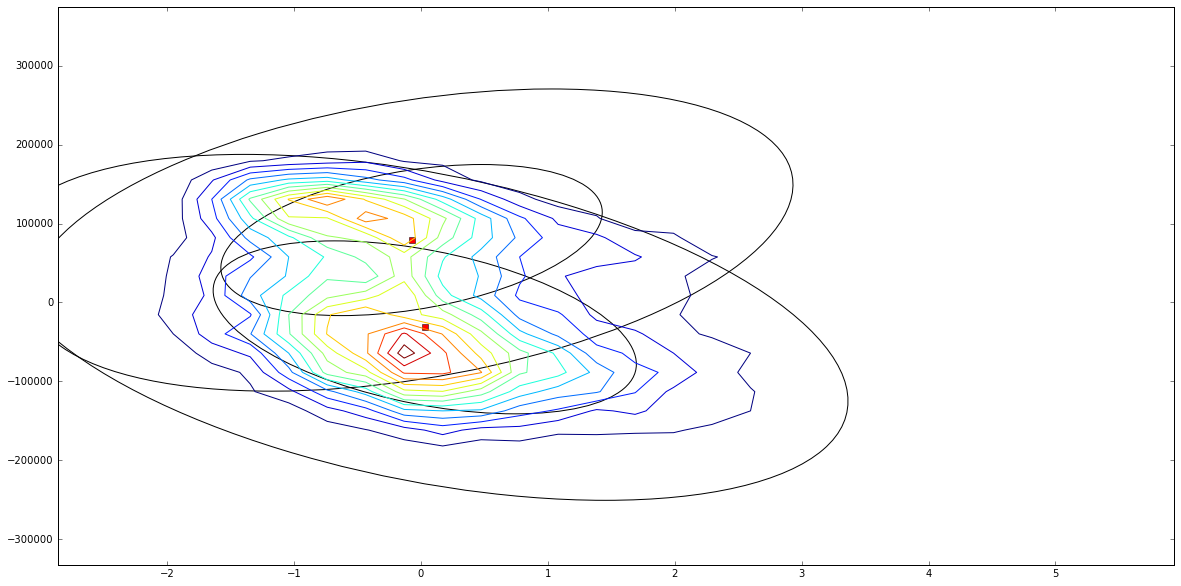

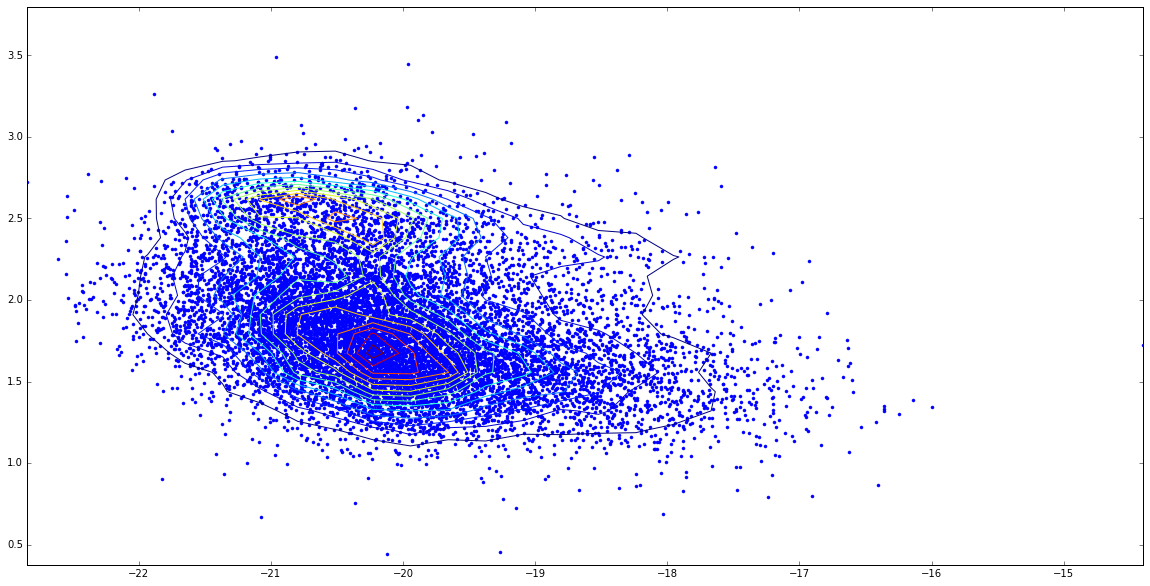

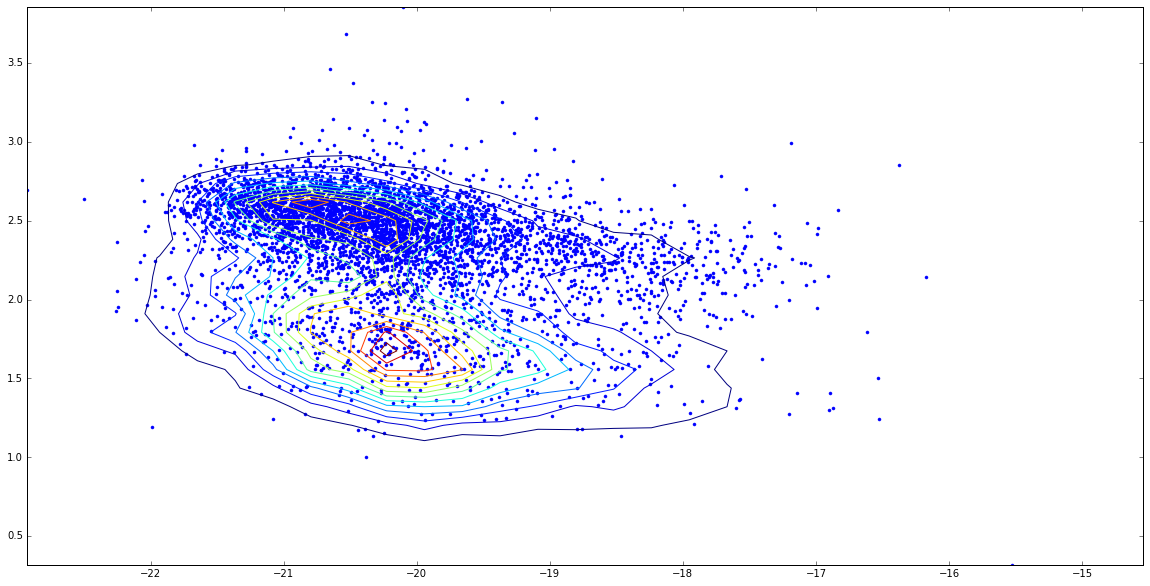

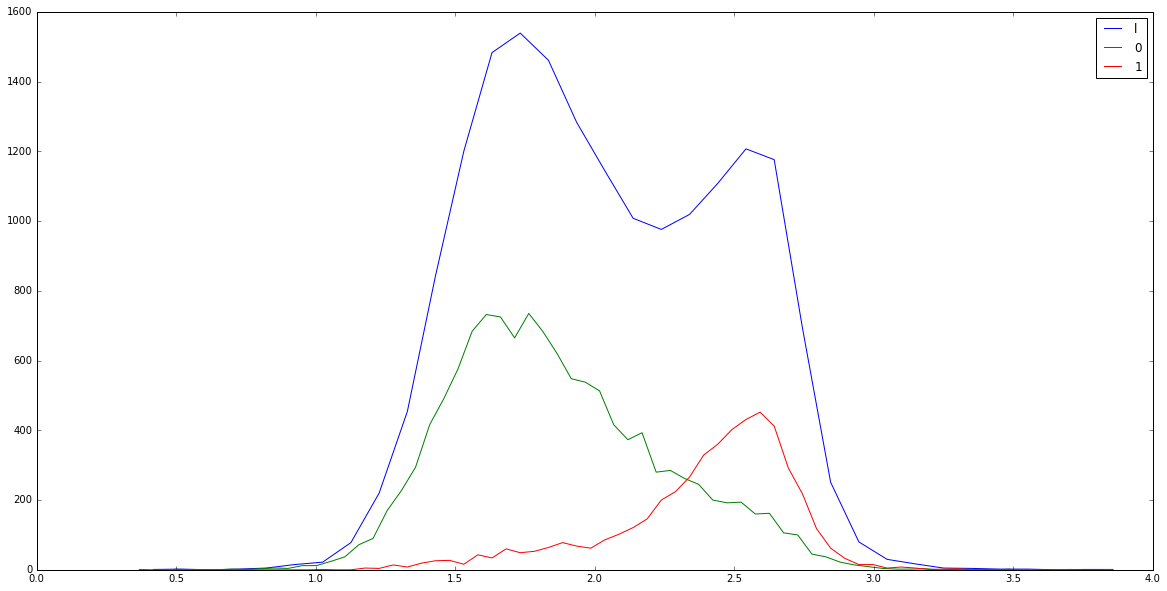

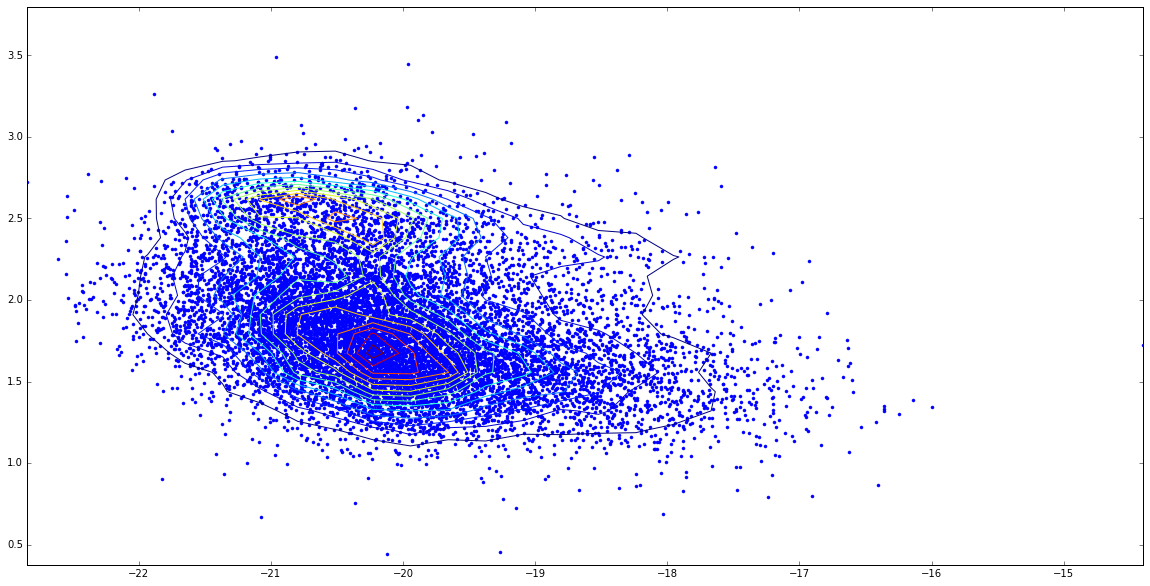

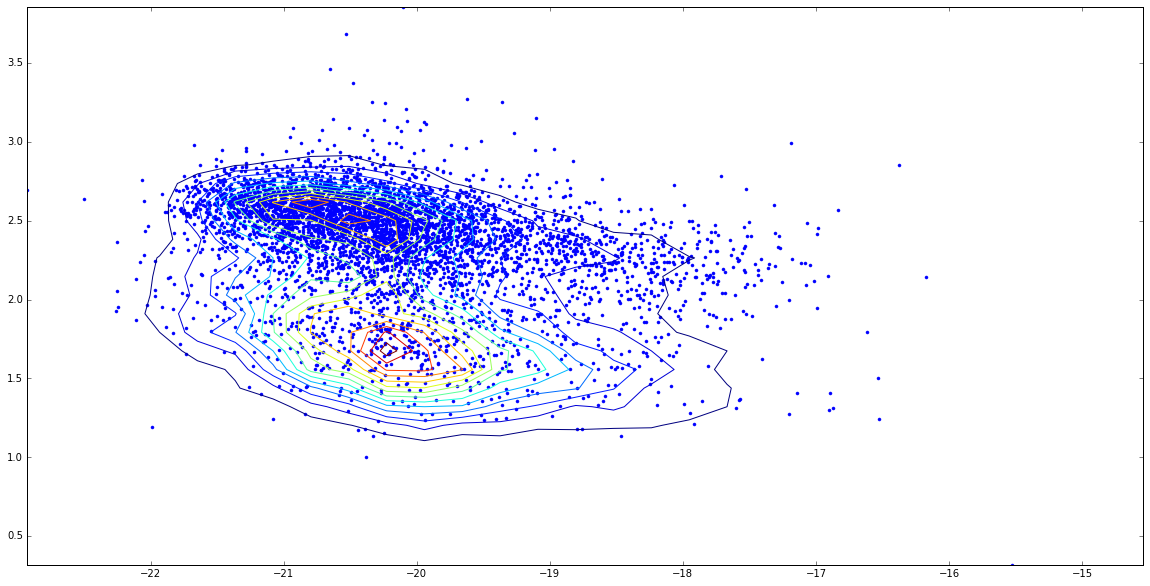

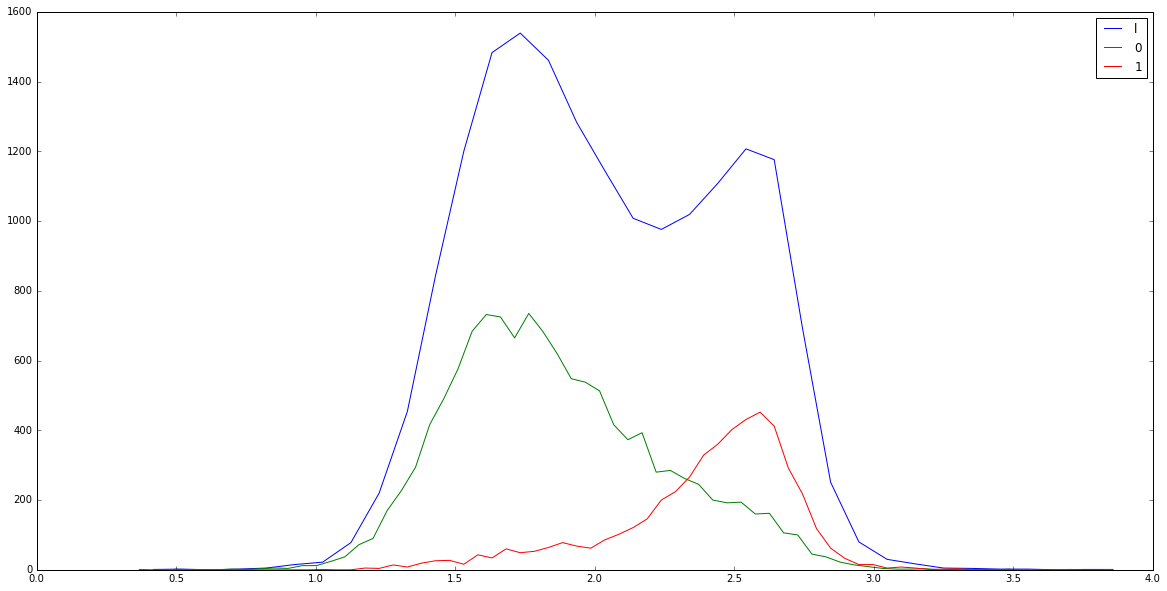

In [7]:
cluster_probs, gmm = cluster_methods.gmm_clustering(data,[[row[0],row[1]*90000,row[7],row[6]] for row in data_scaled],2,500,'mc','full')
# colour-magnitude cut
#cluster_probs, gmm = cluster_methods.gmm_clustering(data,[[row[0],100*row[1]] for row in data_scaled],2,500,'mc','full')

In [39]:
clusters_zero = []

for row in cluster_probs:
    if row[0] > 0.0 and row[0] < .8  and row[1] > 0.01 and row[1] < .8:
        clusters_zero.append(1)
    else:
        clusters_zero.append(0)
        
clusters_zero = np.array(clusters_zero) 


cluster_membership = np.argmax(cluster_probs.T[:2], axis=0)

cluster_probs_excluding_green_valley = np.argmax(cluster_probs[clusters_zero==0].T[1:],axis=0)

In [135]:
x = np.array([row[0] for row in data])
y = np.array([row[1] for row in data])

(1, 3.5)

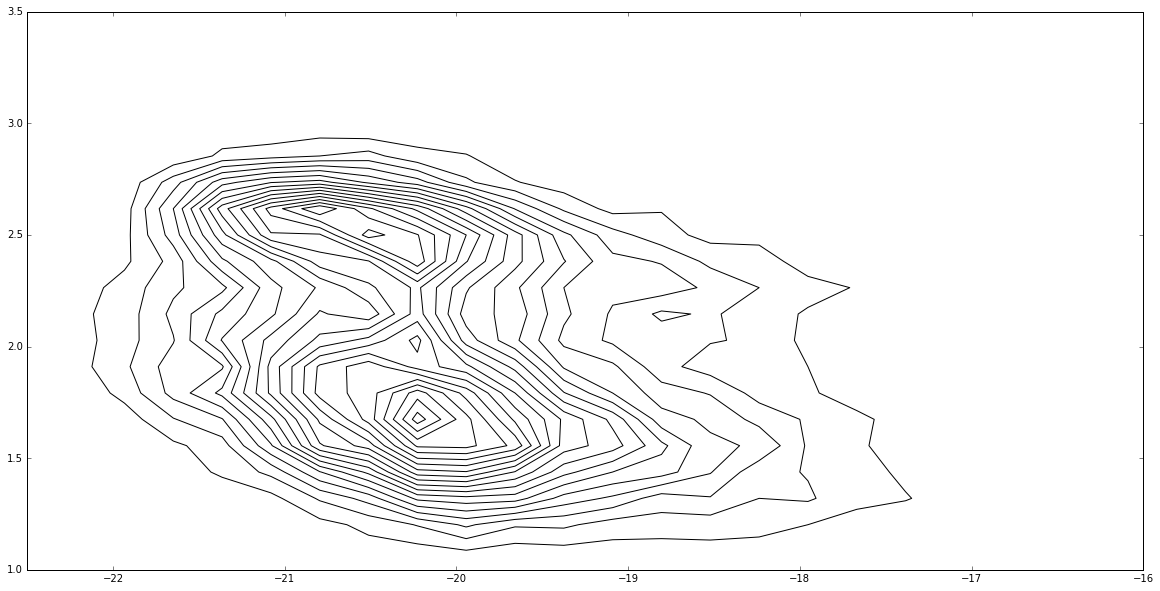

In [41]:
plt.figure(figsize=(20,10))

pt.plot_contour(x,y,colours='k')
plt.plot(x[clusters_zero == 1],y[clusters_zero == 1],'.')
#plt.plot(x[clusters_one == 1],y[clusters_one == 1],'.')
#pt.plot_contour(x[clusters_zero == 1],y[clusters_zero == 1])
#pt.plot_contour(x[clusters_one == 1],y[clusters_one == 1])

plt.xlim(-22.5,-16)
plt.ylim(1,3.5)

In [42]:
x1 = []
y1 = []

for i,row in enumerate(y):
    if cluster_membership[i] == 0:
        if clusters_zero[i] == 0:
            y1.append(row)
            x1.append(x[i])
x2 = []            
y2 = []

for i,row in enumerate(y):
    if cluster_membership[i] == 1:
        if clusters_zero[i] == 0:
            y2.append(row)
            x2.append(x[i])
            
bluex = []
bluey = []

for i,row in enumerate(y):
    if cluster_membership[i] == 0:
        bluey.append(row)
        bluex.append(x[i])
        
redx = []            
redy = []

for i,row in enumerate(y):
    if cluster_membership[i] == 1:
        redy.append(row)
        redx.append(x[i])

In [43]:
def plot_hist(array,bin_num,label,normed=True,set_bin_size=False,bin_size=1,colour='b',alt='norm'):
    """Histogram plotter made by me, versatile"""
    if set_bin_size == True:
        bin_num = float(np.max(array)-np.min(array))/bin_size
        n, bins = np.histogram(array,bins=int(bin_num),normed=normed)
    else:
        n, bins = np.histogram(array,bins=bin_num,normed=normed)
    if alt == 'bluey':
        plt.plot(bins[1:],n,'--',linewidth=3,color=colour)
    else:
        plt.plot(bins[1:],n,label=label,drawstyle='steps-mid',linewidth=3,color=colour)
    return 

(array([   0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.]),
 <a list of 8 Text yticklabel objects>)

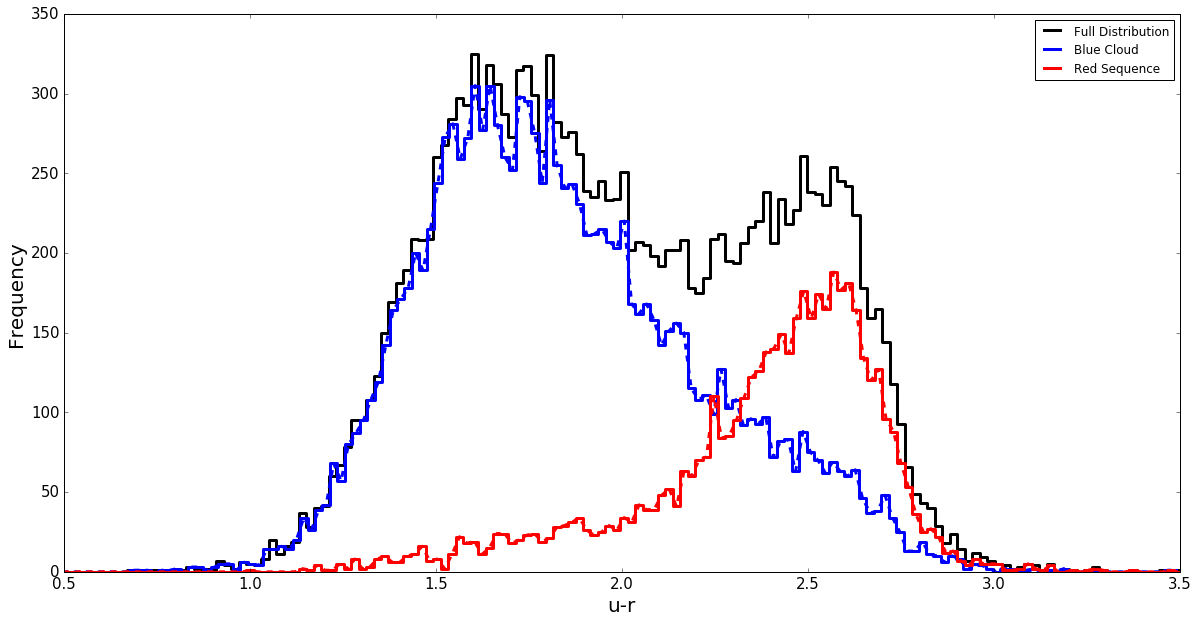

In [136]:
plt.figure(figsize=(20,10))
plot_hist(y,200,'Full Distribution',set_bin_size=True,bin_size=0.02,normed=False,colour='k')
#plot_hist(y[clusters_zero == 1],200,'Green Valley',set_bin_size=True,bin_size=0.02,normed=False,colour='g')

#for i in range(2):
#    pt.plot_hist(y[cluster_membership==i],200,str(i),set_bin_size=True,bin_size=0.05,normed=False)

plot_hist(y1,200,'Blue Cloud',set_bin_size=True,bin_size=0.02,normed=False,colour='b')
plot_hist(bluey,200,'Blue Cloud',set_bin_size=True,bin_size=0.02,normed=False,colour='b',alt='bluey')
plot_hist(redy,200,'Redsequence',set_bin_size=True,bin_size=0.02,normed=False,colour='r',alt='bluey')

plot_hist(y2,200,'Red Sequence',set_bin_size=True,bin_size=0.02,normed=False,colour='r')
#plot_hist(redy,200,str(i),set_bin_size=True,bin_size=0.05,normed=False)
#plot_hist(bluey,200,str(i),set_bin_size=True,bin_size=0.05,normed=False)

plt.xlim(0.5,3.5)
plt.xlabel('u-r',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.legend()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [74]:
cluster_probs[1]

array([  1.00000000e+000,   4.45476516e-161])

In [90]:
blue_Mgalaxies = []
small_blue = []
for i,row in enumerate(cluster_membership):
    if cluster_membership[i] == 0:
        blue_Mgalaxies.append(reduced_rlim_Mgalaxies[i])
        if cluster_probs[i][0] > 0.999999999999:
            small_blue.append(reduced_rlim_Mgalaxies[i])

12390

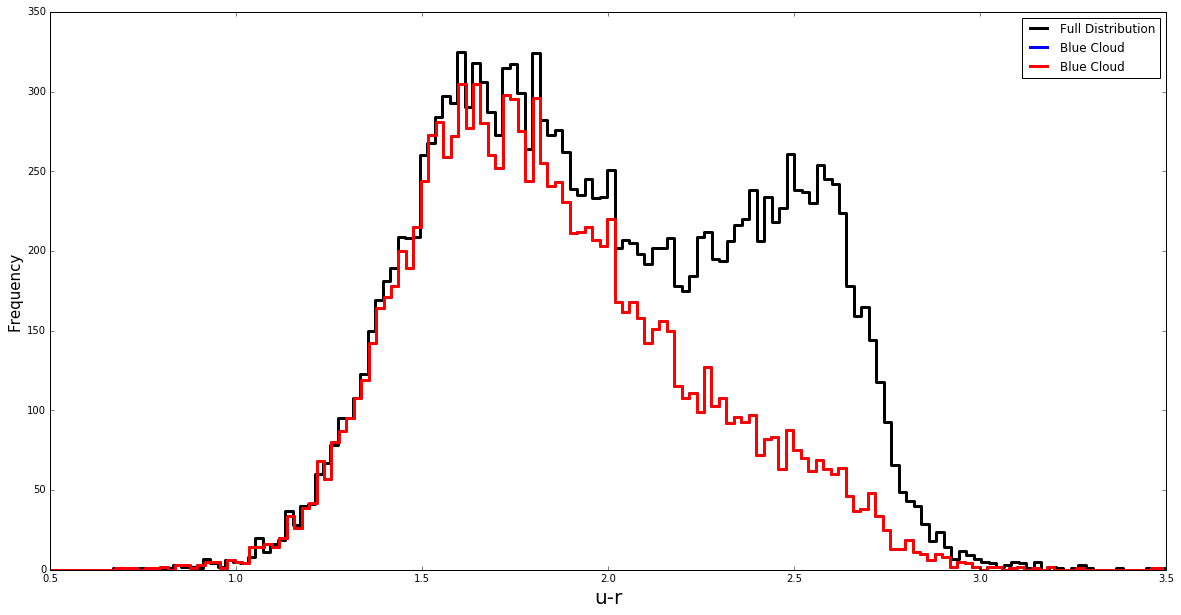

In [91]:
plt.figure(figsize=(20,10))
plot_hist(np.array([row[1] for row in data]),200,'Full Distribution',set_bin_size=True,bin_size=0.02,normed=False,colour='k')
#plot_hist([row[3]-row[5] for row in reduced_data],200,'Full Distribution',set_bin_size=True,bin_size=0.02,normed=False,colour='k')
plot_hist([row[3]-row[5] for row in blue_Mgalaxies],200,'Blue Cloud',set_bin_size=True,bin_size=0.02,normed=False,colour='b')
plot_hist([row[3]-row[5] for row in small_blue],200,'Blue Cloud',set_bin_size=True,bin_size=0.02,normed=False,colour='r')


plt.xlim(0.5,3.5)
plt.xlabel('u-r',fontsize=20)
plt.ylabel('Frequency',fontsize=15)
plt.legend()

len(y1)

In [47]:
len(blue_Mgalaxies), len(y)

(12390, 17334)

In [48]:
# begin creating colour-magnitude diagrams
# the different colours
names = ['FUV','NUV','u','g','r','i','z','Y','J','H','K','W1','W2']
indices = [i for i in range(2,14)]   
colour_combos = [i for i in itertools.combinations(indices,2)]
len(colour_combos), len(names), len(indices)

(66, 13, 12)

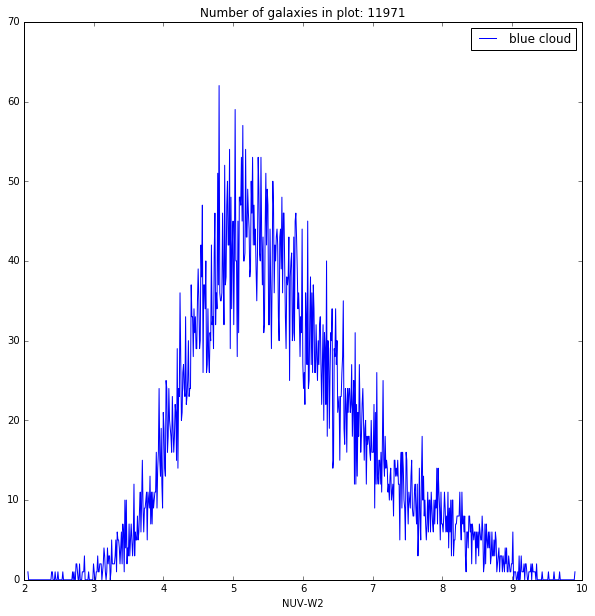

In [49]:
# histograms
plt.figure(figsize=(10,10))
colrow= [2,13]
y = [row[colrow[0]]-row[colrow[1]] for row in [row for row in blue_Mgalaxies if 0.08>row[0]>0.004 and 999>row[colrow[0]]-row[colrow[1]] > -999]]  
pt.plot_hist(y,200,'blue cloud',set_bin_size=True, bin_size=0.01,normed=False)
plt.title('Number of galaxies in plot: '+str(len(y)))
plt.legend()
label = names[colrow[0]-1]+'-'+names[colrow[1]-1]
plt.xlabel(label)

In [51]:
# make blue galaxies all with photometry, ignore FUV
reducedblue = [row for row in blue_Mgalaxies if row[2]>-999 and row[3]>-999 and row[4]>-999 and row[5]>-999 and 
                                                row[6]>-999 and row[7]>-999 and row[8]>-999 and row[9]>-999 and 
                                                row[10]>-999 and row[11]>-999 and row[12]>-999 and row[13]>-999]

test_data = [row for row in reduced_rlim_Mgalaxies if row[2]>-999 and row[3]>-999 and row[4]>-999 and row[5]>-999 and 
                                                row[6]>-999 and row[7]>-999 and row[8]>-999 and row[9]>-999 and 
                                                row[10]>-999 and row[11]>-999 and row[12]>-999 and row[13]>-999]

In [50]:
for colrow in colour_combos:
    x = [row[colrow[1]] for row in reducedblue]
    y = [row[colrow[0]]-row[colrow[1]] for row in reducedblue]  
    xx,yy,f = kernel_density_estimation(x,y)
    
    fig = plt.figure(figsize=(20,10))
    ax = fig.gca()
    # Contourf plot
    cfset = ax.contourf(xx, yy, f,levels=[np.power(x,2) for x in np.arange(0.001,0.9,0.05)], cmap='ocean_r',)
    ## Or kernel density estimate plot instead of the contourf plot
    #ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
    cset = ax.contour(xx, yy, f,levels=[np.power(x,2) for x in np.arange(0.001,0.9,0.05)], colors='k',alpha=1.)
    # Label plot
    ax.clabel(cset, inline=1, fontsize=10)
    label = names[colrow[0]-1]+'-'+names[colrow[1]-1]
    ax.set_ylabel(label,fontsize=20)
    ax.set_xlabel(names[colrow[1]-1],fontsize =20)
    ax.set_title(len(x))
    #ax.set_ylim(0,7.5)
    #ax.set_xlim(-23,-17)
    savestring = '/home/calum/Documents/Mphys_data/images/'+label
    plt.savefig(savestring)
    plt.close()

NameError: name 'reducedblue' is not defined

In [52]:
for colrow in colour_combos:
    print(names[colrow[0]-1]+'-'+names[colrow[1]-1])
    x = [row[colrow[1]] for row in test_data]
    y = [row[colrow[0]]-row[colrow[1]] for row in test_data]  
    xx,yy,f = kernel_density_estimation(x,y)
    
    first_len = len(x)
    
    fig = plt.figure(figsize=(20,10))
    ax = fig.gca()
    # Contourf plot
    cfset = ax.contourf(xx, yy, f,levels=[np.power(x,2) for x in np.arange(0.001,0.9,0.05)], cmap='ocean_r',)
    ## Or kernel density estimate plot instead of the contourf plot
    #ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
    
    x = [row[colrow[1]] for row in reducedblue]
    y = [row[colrow[0]]-row[colrow[1]] for row in reducedblue]  
    xx,yy,f = kernel_density_estimation(x,y)
    
    cset = ax.contour(xx, yy, f,levels=[np.power(x,2) for x in np.arange(0.001,0.9,0.05)], colors='k',alpha=1.)
    # Label plot
    ax.clabel(cset, inline=1, fontsize=10)
    label = names[colrow[0]-1]+'-'+names[colrow[1]-1]
    ax.set_ylabel(label,fontsize=20)
    ax.set_xlabel(names[colrow[1]-1],fontsize =20)
    title_string = str(len(x))+str(first_len)
    ax.set_title(title_string)
    #ax.set_ylim(0,7.5)
    #ax.set_xlim(-23,-17)
    savestring = '/home/calum/Documents/Mphys_data/images/overplot'+label
    plt.savefig(savestring)
    plt.close()

NUV-u
NUV-g
NUV-r
NUV-i
NUV-z
NUV-Y
NUV-J
NUV-H
NUV-K
NUV-W1
NUV-W2
u-g
u-r
u-i
u-z
u-Y
u-J
u-H
u-K
u-W1
u-W2
g-r
g-i
g-z
g-Y
g-J
g-H
g-K
g-W1
g-W2


/home/calum/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


r-i
r-z
r-Y
r-J
r-H
r-K
r-W1
r-W2
i-z
i-Y
i-J
i-H
i-K
i-W1
i-W2
z-Y
z-J
z-H
z-K
z-W1
z-W2
Y-J
Y-H
Y-K
Y-W1
Y-W2
J-H
J-K
J-W1
J-W2
H-K
H-W1
H-W2
K-W1
K-W2
W1-W2


In [55]:
#plt.figure(figsize=(20,80))
colrow= [2,5]

x = [row[colrow[1]] for row in [row for row in blue_Mgalaxies if 0.1>row[0]>0.004 and 999>row[colrow[0]]-row[colrow[1]] > -999]]
y = [row[colrow[0]]-row[colrow[1]] for row in [row for row in blue_Mgalaxies if 0.1>row[0]>0.004 and 999>row[colrow[0]]-row[colrow[1]] > -999]]  
xx,yy,f = kernel_density_estimation(x,y)



In [60]:
colrow= [2,5]

fig = plt.figure(figsize=(20,10))
ax = fig.gca()
# Contourf plot
cfset = ax.contourf(xx, yy, f,levels=[np.power(x,2) for x in np.arange(0.001,0.9,0.05)], cmap='ocean_r',)
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(xx, yy, f,levels=[np.power(x,2) for x in np.arange(0.001,0.9,0.05)], colors='k',alpha=1.)
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
label = names[colrow[0]-1]+'-'+names[colrow[1]-1]
ax.set_ylabel(label,fontsize=20)
ax.set_xlabel(names[colrow[1]-1],fontsize =20)
ax.set_ylim(0,7.5)
ax.set_xlim(-23,-17)
plt.close()

In [188]:
#plt.figure(figsize=(20,80))
colrow= [3,5]

urx = [row[colrow[1]] for row in [row for row in reduced_rlim_Mgalaxies if 0.08>row[0]>0.004 and 3.5>row[colrow[0]]-row[colrow[1]] > 0]]
ury = [row[colrow[0]]-row[colrow[1]] for row in [row for row in reduced_rlim_Mgalaxies if 0.08>row[0]>0.004 and 3.5>row[colrow[0]]-row[colrow[1]] > 0]]  
urxx,uryy,urf = kernel_density_estimation(urx,ury)

(-23, -19.2)

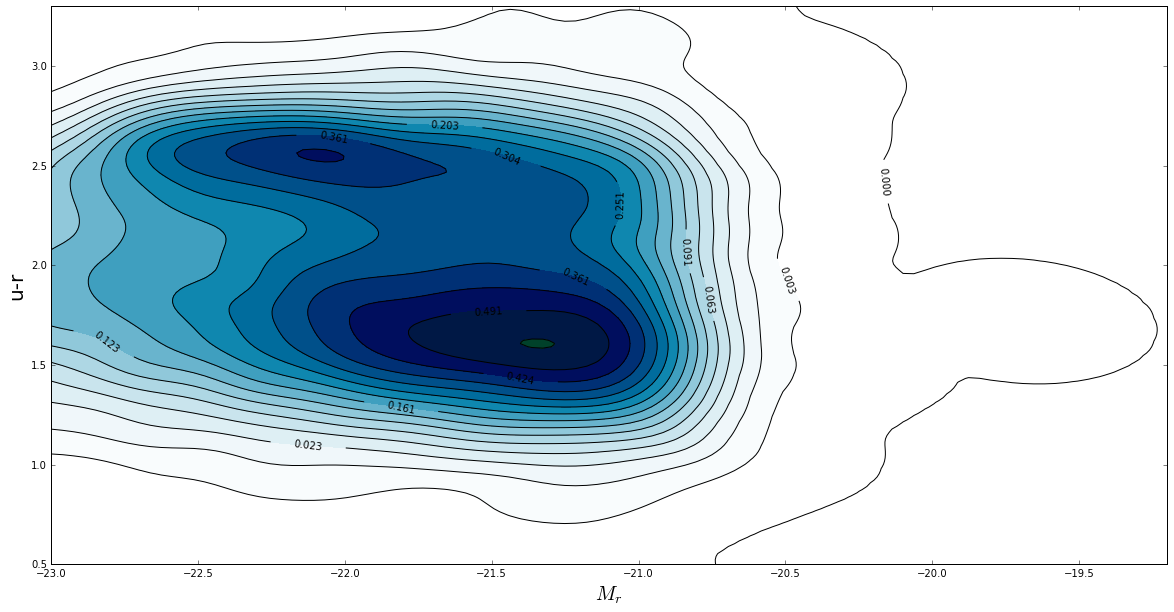

In [189]:
colrow= [3,5]

fig = plt.figure(figsize=(20,10))
ax = fig.gca()
# Contourf plot
cfset = ax.contourf(urxx, uryy, urf,levels=[np.power(x,2) for x in np.arange(0.001,0.9,0.05)], cmap='ocean_r',)
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(urxx, uryy, urf,levels=[np.power(x,2) for x in np.arange(0.001,0.9,0.05)],colors='k',alpha=1.)
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
label = names[colrow[0]-1]+'-'+names[colrow[1]-1]
ax.set_ylabel(label,fontsize=20)
ax.set_xlabel('$M_{r}$',fontsize=20)
ax.set_ylim(0.5,3.3)
ax.set_xlim(-23,-19.2)

In [45]:
# make blue galaxies all with photometry, ignore FUV
reducedblue = [row for row in blue_Mgalaxies if row[2]>-999 and row[3]>-999 and row[4]>-999 and row[5]>-999 and 
                                                row[6]>-999 and row[7]>-999 and row[8]>-999 and row[9]>-999 and 
                                                row[10]>-999 and row[11]>-999 and row[12]>-999 and row[13]>-999]

In [44]:
test_data = [row for row in reduced_rlim_Mgalaxies if row[2]>-999 and row[3]>-999 and row[4]>-999 and row[5]>-999 and 
                                                row[6]>-999 and row[7]>-999 and row[8]>-999 and row[9]>-999 and 
                                                row[10]>-999 and row[11]>-999 and row[12]>-999 and row[13]>-999]

In [90]:
len(reducedblue), len(blue_Mgalaxies), len(reduced_rlim_Mgalaxies), len(reduced_data)

(11030, 12390, 17334, 15575)

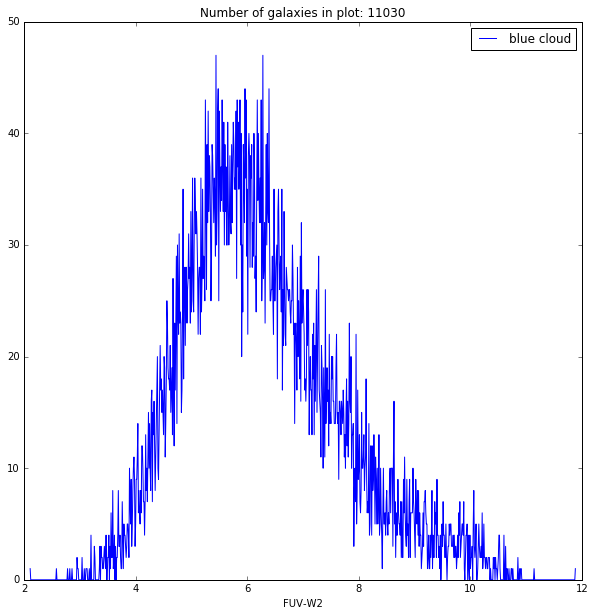

In [67]:
# histograms
plt.figure(figsize=(10,10))
colrow= [1,13]
y = [row[colrow[0]]-row[colrow[1]] for row in [row for row in reducedblue]]  
pt.plot_hist(y,200,'blue cloud',set_bin_size=True, bin_size=0.01,normed=False)
plt.title('Number of galaxies in plot: '+str(len(y)))
plt.legend()
label = names[colrow[0]-1]+'-'+names[colrow[1]-1]
plt.xlabel(label)

In [54]:
##########################################################

In [55]:
colrow = [2,5]
tNUVrx = [row[colrow[1]] for row in test_data]
tNUVry = [row[colrow[0]]-row[colrow[1]] for row in test_data]  
tNUVrxx,tNUVryy,tNUVrf = kernel_density_estimation(tNUVrx,tNUVry)

NUVrx = [row[colrow[1]] for row in reducedblue]
NUVry = [row[colrow[0]]-row[colrow[1]] for row in reducedblue]  
NUVrxx,NUVryy,NUVrf = kernel_density_estimation(NUVrx,NUVry)

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.]),
 <a list of 7 Text yticklabel objects>)

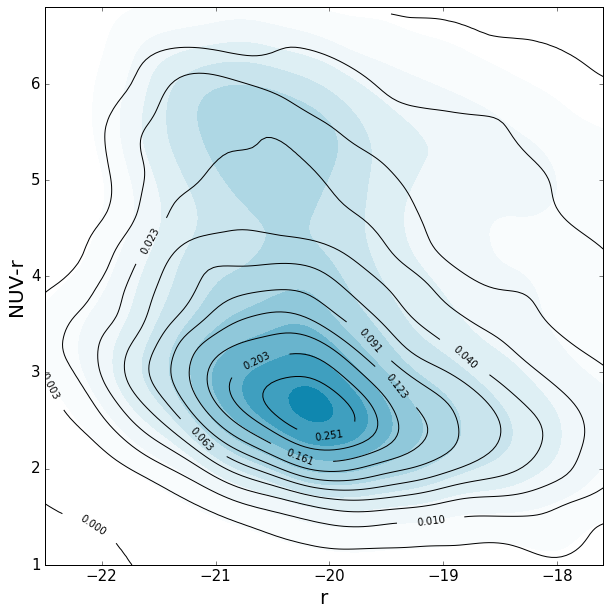

In [127]:
colrow = [2,5]


xx,yy,f = tNUVrxx,tNUVryy,tNUVrf

fig = plt.figure(figsize=(10,10))
ax = fig.gca()
# Contourf plot
cfset = ax.contourf(xx, yy, f,levels=[np.power(x,2) for x in np.arange(0.001,0.9,0.05)], cmap='ocean_r',)
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])

xx,yy,f = NUVrxx,NUVryy,NUVrf

cset = ax.contour(xx, yy, f,levels=[np.power(x,2) for x in np.arange(0.001,0.9,0.05)], colors='k',alpha=1.)
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
label = names[colrow[0]-1]+'-'+names[colrow[1]-1]
ax.set_ylabel(label,fontsize=20)
ax.set_xlabel(names[colrow[1]-1],fontsize =20)
ax.set_ylim(1,6.8)
ax.set_xlim(-22.5,-17.6)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [57]:
colrow = [2,8]
tNUVYx = [row[colrow[1]] for row in test_data]
tNUVYy = [row[colrow[0]]-row[colrow[1]] for row in test_data]  
tNUVYxx,tNUVYyy,tNUVYf = kernel_density_estimation(tNUVYx,tNUVYy)

NUVYx = [row[colrow[1]] for row in reducedblue]
NUVYy = [row[colrow[0]]-row[colrow[1]] for row in reducedblue]  
NUVYxx,NUVYyy,NUVYf = kernel_density_estimation(NUVYx,NUVYy)

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 <a list of 8 Text yticklabel objects>)

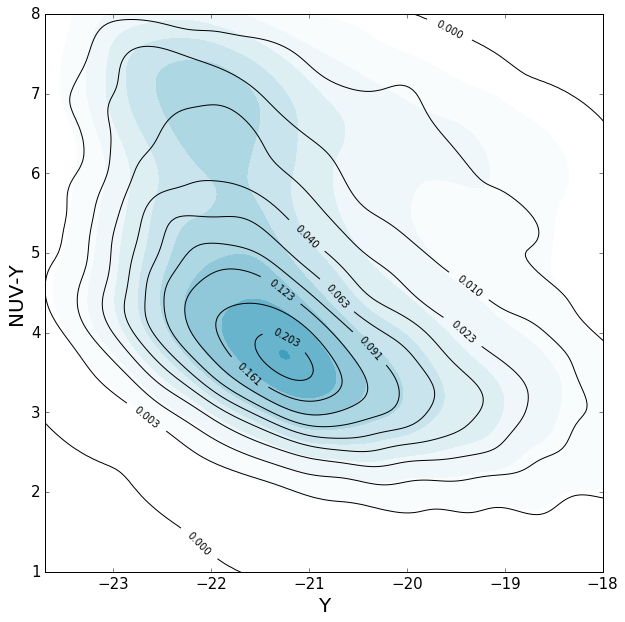

In [128]:
colrow = [2,8]


xx,yy,f = tNUVYxx,tNUVYyy,tNUVYf

fig = plt.figure(figsize=(10,10))
ax = fig.gca()
# Contourf plot
cfset = ax.contourf(xx, yy, f,levels=[np.power(x,2) for x in np.arange(0.001,0.9,0.05)], cmap='ocean_r',)
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])

xx,yy,f = NUVYxx,NUVYyy,NUVYf

cset = ax.contour(xx, yy, f,levels=[np.power(x,2) for x in np.arange(0.001,0.9,0.05)], colors='k',alpha=1.)
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
label = names[colrow[0]-1]+'-'+names[colrow[1]-1]
ax.set_ylabel(label,fontsize=20)
ax.set_xlabel(names[colrow[1]-1],fontsize =20)
ax.set_ylim(1,8)
ax.set_xlim(-23.7,-18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [59]:
colrow = [2,12]
tNUVW1x = [row[colrow[1]] for row in test_data]
tNUVW1y = [row[colrow[0]]-row[colrow[1]] for row in test_data]  
tNUVW1xx,tNUVW1yy,tNUVW1f = kernel_density_estimation(tNUVW1x,tNUVW1y)

NUVW1x = [row[colrow[1]] for row in reducedblue]
NUVW1y = [row[colrow[0]]-row[colrow[1]] for row in reducedblue]  
NUVW1xx,NUVW1yy,NUVW1f = kernel_density_estimation(NUVW1x,NUVW1y)

(array([  2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.]),
 <a list of 9 Text yticklabel objects>)

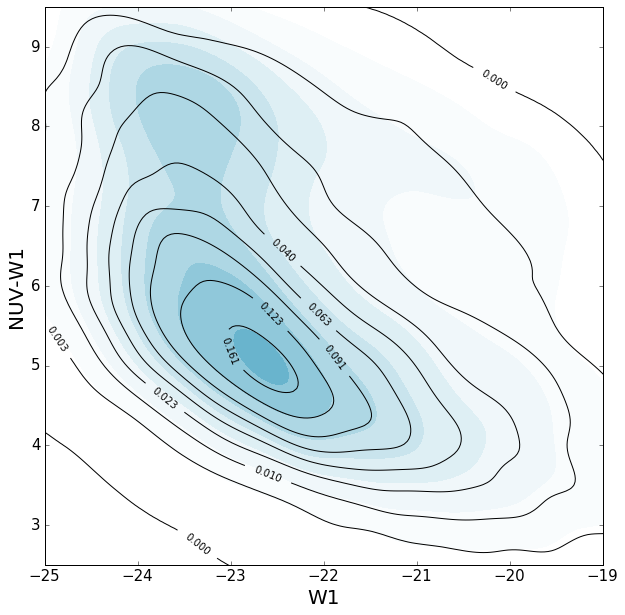

In [130]:
colrow = [2,12]

xx,yy,f = tNUVW1xx,tNUVW1yy,tNUVW1f

fig = plt.figure(figsize=(10,10))
ax = fig.gca()
# Contourf plot
cfset = ax.contourf(xx, yy, f,levels=[np.power(x,2) for x in np.arange(0.001,0.9,0.05)], cmap='ocean_r',)
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])

xx,yy,f = NUVW1xx,NUVW1yy,NUVW1f

cset = ax.contour(xx, yy, f,levels=[np.power(x,2) for x in np.arange(0.001,0.9,0.05)], colors='k',alpha=1.)
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
label = names[colrow[0]-1]+'-'+names[colrow[1]-1]
ax.set_ylabel(label,fontsize=20)
ax.set_xlabel(names[colrow[1]-1],fontsize =20)
ax.set_ylim(2.5,9.5)
ax.set_xlim(-25,-19)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [61]:
colrow = [5,9]
trJx = [row[colrow[1]] for row in test_data]
trJy = [row[colrow[0]]-row[colrow[1]] for row in test_data]  
trJxx,trJyy,trJf = kernel_density_estimation(trJx,trJy)

rJx = [row[colrow[1]] for row in reducedblue]
rJy = [row[colrow[0]]-row[colrow[1]] for row in reducedblue]  
rJxx,rJyy,rJf = kernel_density_estimation(rJx,rJy)

(array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 <a list of 6 Text yticklabel objects>)

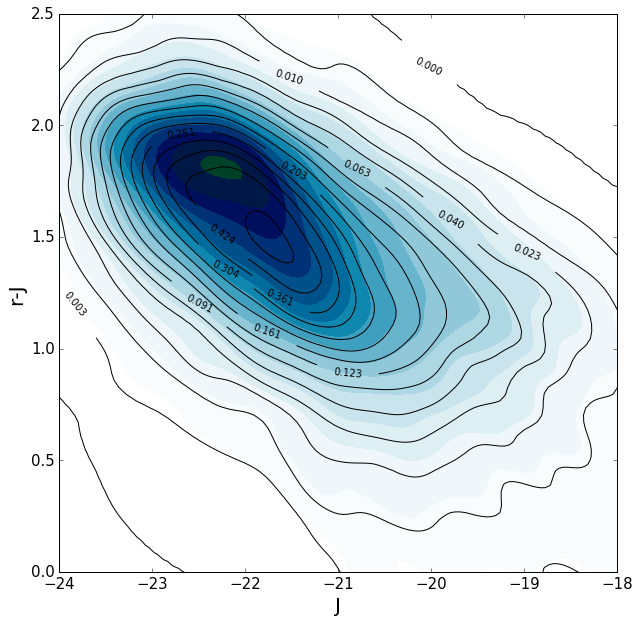

In [132]:
colrow = [5,9]

xx,yy,f = trJxx,trJyy,trJf 

fig = plt.figure(figsize=(10,10))
ax = fig.gca()
# Contourf plot
cfset = ax.contourf(xx, yy, f,levels=[np.power(x,2) for x in np.arange(0.001,0.9,0.05)], cmap='ocean_r',)
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])

xx,yy,f = rJxx,rJyy,rJf 

cset = ax.contour(xx, yy, f,levels=[np.power(x,2) for x in np.arange(0.001,0.9,0.05)], colors='k',alpha=1.)
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
label = names[colrow[0]-1]+'-'+names[colrow[1]-1]
ax.set_ylabel(label,fontsize=20)
ax.set_xlabel(names[colrow[1]-1],fontsize =20)
ax.set_ylim(0,2.5)
ax.set_xlim(-24,-18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [63]:
colrow = [3,8]
tuYx = [row[colrow[1]] for row in test_data]
tuYy = [row[colrow[0]]-row[colrow[1]] for row in test_data]  
tuYxx,tuYyy,tuYf = kernel_density_estimation(tuYx,tuYy)

uYx = [row[colrow[1]] for row in reducedblue]
uYy = [row[colrow[0]]-row[colrow[1]] for row in reducedblue]  
uYxx,uYyy,uYf = kernel_density_estimation(uYx,uYy)

(array([ 1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5]),
 <a list of 7 Text yticklabel objects>)

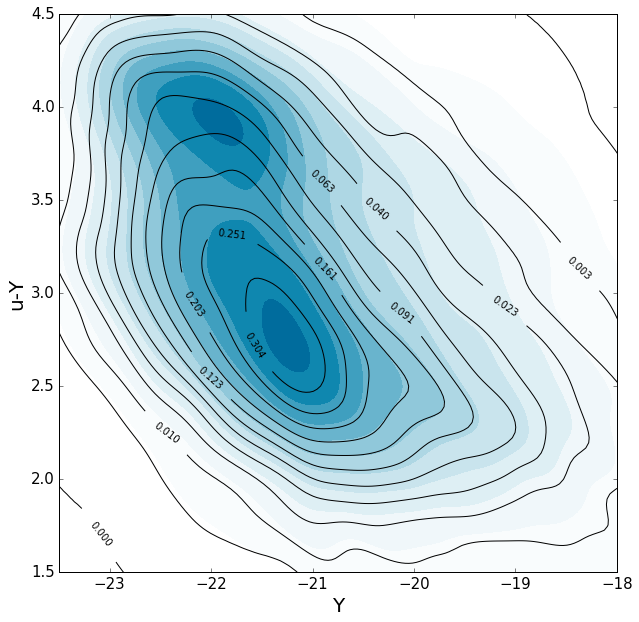

In [115]:
colrow = [3,8]

xx,yy,f = tuYxx,tuYyy,tuYf 

fig = plt.figure(figsize=(10,10))
ax = fig.gca()
# Contourf plot
cfset = ax.contourf(xx, yy, f,levels=[np.power(x,2) for x in np.arange(0.001,0.9,0.05)], cmap='ocean_r',)
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])

xx,yy,f = uYxx,uYyy,uYf 

cset = ax.contour(xx, yy, f,levels=[np.power(x,2) for x in np.arange(0.001,0.9,0.05)], colors='k',alpha=1.)
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
label = names[colrow[0]-1]+'-'+names[colrow[1]-1]
ax.set_ylabel(label,fontsize=20)
ax.set_xlabel(names[colrow[1]-1],fontsize =20)
ax.set_ylim(1.5,4.5)
ax.set_xlim(-23.5,-18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [65]:
colrow = [3,5]
turx = [row[colrow[1]] for row in test_data]
tury = [row[colrow[0]]-row[colrow[1]] for row in test_data]  
turxx,turyy,turf = kernel_density_estimation(turx,tury)

urx = [row[colrow[1]] for row in reducedblue]
ury = [row[colrow[0]]-row[colrow[1]] for row in reducedblue]  
urxx,uryy,urf = kernel_density_estimation(urx,ury)

(array([ 1. ,  1.5,  2. ,  2.5,  3. ]), <a list of 5 Text yticklabel objects>)

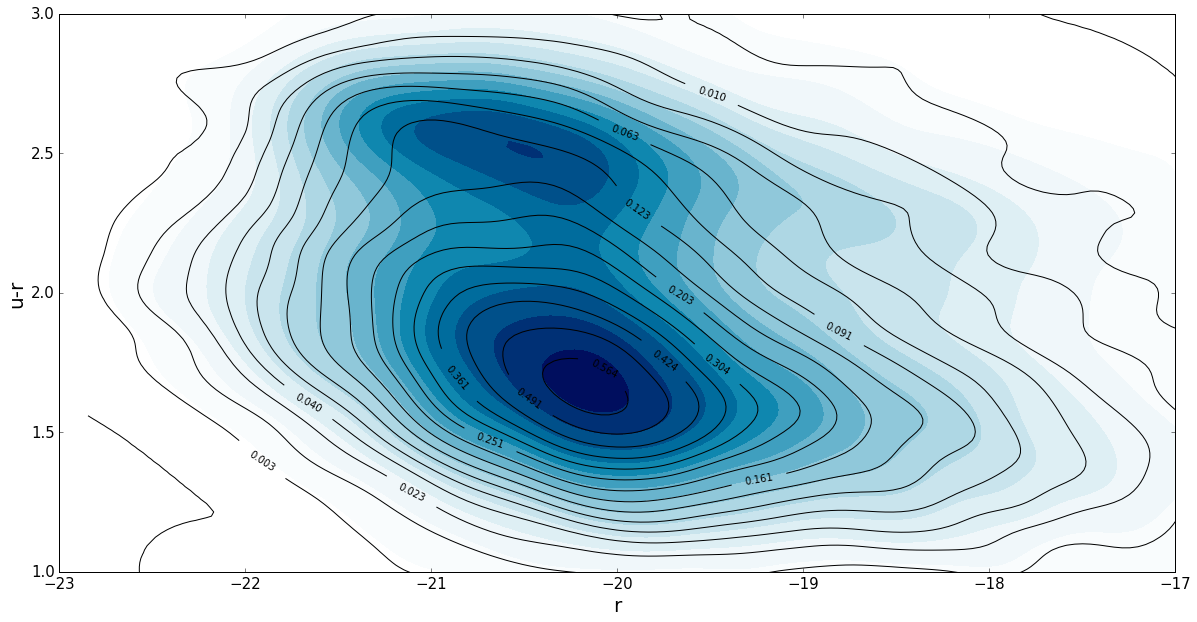

In [126]:
colrow = [3,5]

xx,yy,f = turxx,turyy,turf

fig = plt.figure(figsize=(20,10))
ax = fig.gca()
# Contourf plot
cfset = ax.contourf(xx, yy, f,levels=[np.power(x,2) for x in np.arange(0.001,0.9,0.05)], cmap='ocean_r',)
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])

xx,yy,f = urxx,uryy,urf 

cset = ax.contour(xx, yy, f,levels=[np.power(x,2) for x in np.arange(0.001,0.9,0.05)], colors='k',alpha=1.)
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
label = names[colrow[0]-1]+'-'+names[colrow[1]-1]
ax.set_ylabel(label,fontsize=20)
ax.set_xlabel(names[colrow[1]-1],fontsize =20)
ax.set_ylim(1,3)
ax.set_xlim(-23,-17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [67]:
colrow = [8,13]
tYW2x = [row[colrow[1]] for row in test_data]
tYW2y = [row[colrow[0]]-row[colrow[1]] for row in test_data]  
tYW2xx,tYW2yy,tYW2f = kernel_density_estimation(tYW2x,tYW2y)

YW2x = [row[colrow[1]] for row in reducedblue]
YW2y = [row[colrow[0]]-row[colrow[1]] for row in reducedblue]  
YW2xx,YW2yy,YW2f = kernel_density_estimation(YW2x,YW2y)

(array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ]),
 <a list of 6 Text yticklabel objects>)

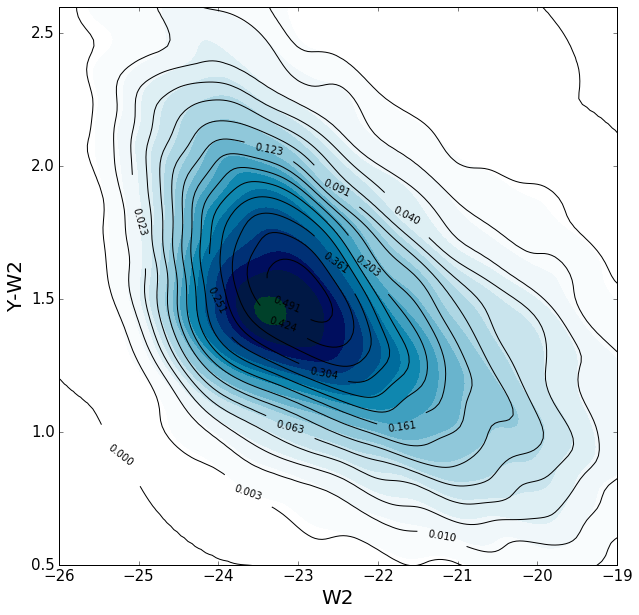

In [120]:
colrow = [8,13]

xx,yy,f = tYW2xx,tYW2yy,tYW2f

fig = plt.figure(figsize=(10,10))
ax = fig.gca()
# Contourf plot
cfset = ax.contourf(xx, yy, f,levels=[np.power(x,2) for x in np.arange(0.001,0.9,0.05)], cmap='ocean_r',)
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])

xx,yy,f = YW2xx,YW2yy,YW2f

cset = ax.contour(xx, yy, f,levels=[np.power(x,2) for x in np.arange(0.001,0.9,0.05)], colors='k',alpha=1.)
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
label = names[colrow[0]-1]+'-'+names[colrow[1]-1]
ax.set_ylabel(label,fontsize=20)
ax.set_xlabel(names[colrow[1]-1],fontsize =20)
ax.set_ylim(0.5,2.6)
ax.set_xlim(-26,-19)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [200]:
colrow = [11,13]
col2 = [2,5]
tzW1x = [row[col2[0]]-row[col2[1]] for row in test_data]
tzW1y = [row[colrow[0]]-row[colrow[1]] for row in test_data]  
tzW1xx,tYW1yy,tYW1f = kernel_density_estimation(tzW1x,tzW1y)

zW1x = [row[col2[0]]-row[col2[1]]  for row in reducedblue]
zW1y = [row[colrow[0]]-row[colrow[1]] for row in reducedblue]  
zW1xx,zW1yy,zW1f = kernel_density_estimation(zW1x,zW1y)

15575

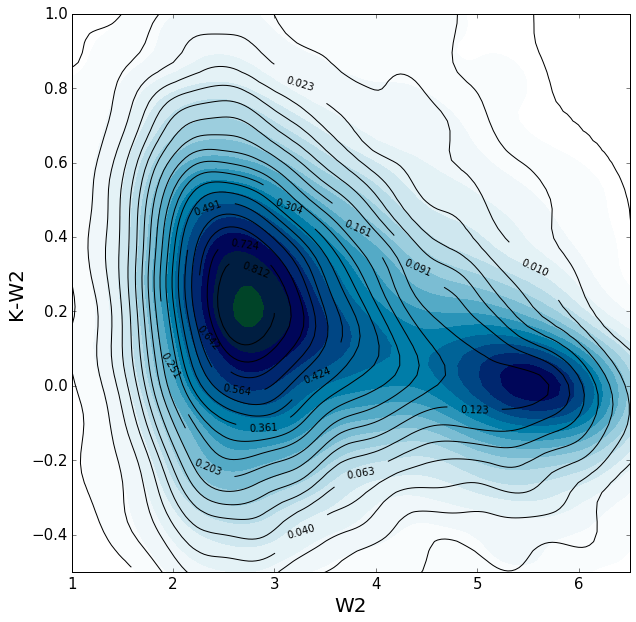

In [201]:
colrow = [11,13]

xx,yy,f = tzW1xx,tYW1yy,tYW1f

fig = plt.figure(figsize=(10,10))
ax = fig.gca()
# Contourf plot
cfset = ax.contourf(xx, yy, f,levels=[np.power(x,2) for x in np.arange(0.001,0.95,0.05)], cmap='ocean_r',)
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])

xx,yy,f = zW1xx,zW1yy,zW1f

cset = ax.contour(xx, yy, f,levels=[np.power(x,2) for x in np.arange(0.001,0.95,0.05)], colors='k',alpha=1.)
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
label = names[colrow[0]-1]+'-'+names[colrow[1]-1]
ax.set_ylabel(label,fontsize=20)
ax.set_xlabel(names[colrow[1]-1],fontsize =20)
ax.set_ylim(-0.5,1)
ax.set_xlim(1,6.5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

len([row[colrow[0]] for row in test_data])

In [205]:
colrow = [11,13]
col2 = [2,5]
ttzW1x = [row[col2[0]]-row[col2[1]] for row in test_data]
ttzW1y = [row[colrow[0]]-row[colrow[1]] for row in test_data]  
ttzW1xx,ttYW1yy,ttYW1f = kernel_density_estimation(ttzW1x,ttzW1y)

pzW1x = [row[col2[0]]-row[col2[1]]  for row in naive_rb]
pzW1y = [row[colrow[0]]-row[colrow[1]] for row in naive_rb]  
pzW1xx,pzW1yy,pzW1f = kernel_density_estimation(pzW1x,pzW1y)

15575

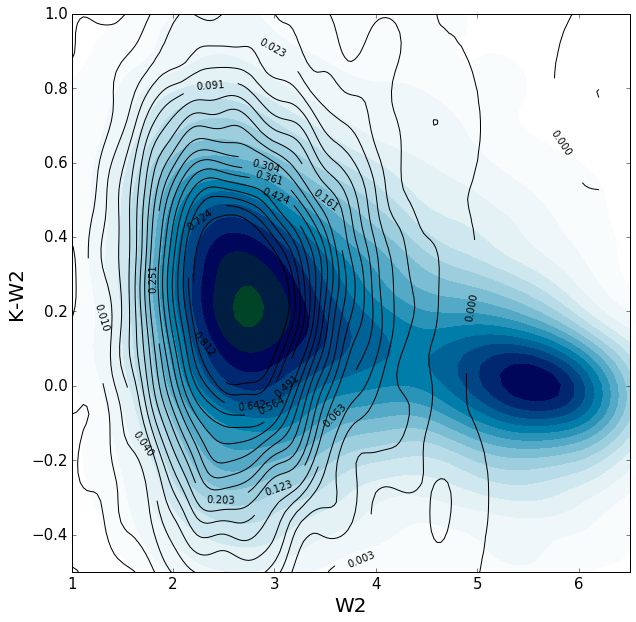

In [206]:
colrow = [11,13]

xx,yy,f = ttzW1xx,ttYW1yy,ttYW1f

fig = plt.figure(figsize=(10,10))
ax = fig.gca()
# Contourf plot
cfset = ax.contourf(xx, yy, f,levels=[np.power(x,2) for x in np.arange(0.001,0.95,0.05)], cmap='ocean_r',)
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])

xx,yy,f = pzW1xx,pzW1yy,pzW1f

cset = ax.contour(xx, yy, f,levels=[np.power(x,2) for x in np.arange(0.001,0.95,0.05)], colors='k',alpha=1.)
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
label = names[colrow[0]-1]+'-'+names[colrow[1]-1]
ax.set_ylabel(label,fontsize=20)
ax.set_xlabel(names[colrow[1]-1],fontsize =20)
ax.set_ylim(-0.5,1)
ax.set_xlim(1,6.5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

len([row[colrow[0]] for row in test_data])

In [146]:
naive_rb = np.load('/home/calum/Documents/Mphys_data/vespa_data/naive_blue.npy')
naive_tdata = np.load('/home/calum/Documents/Mphys_data/vespa_data/tnaive_blue.npy')

(1.4867085056059637, 1.4829972831852001, 1.5001875531164943)

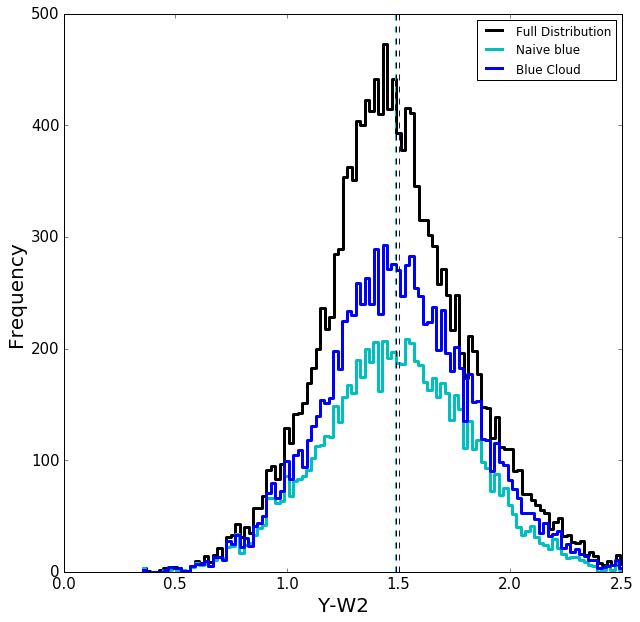

In [185]:
colrow = [8,13]


plt.figure(figsize=(10,10))
plot_hist([row[colrow[0]]-row[colrow[1]] for row in test_data],200,'Full Distribution',set_bin_size=True,bin_size=0.02,normed=False,colour='k')
plot_hist([row[colrow[0]]-row[colrow[1]] for row in naive_rb],200,'Naive blue',set_bin_size=True,bin_size=0.02,normed=False,colour='c')

#plot_hist([row[3]-row[5] for row in reduced_data],200,'Full Distribution',set_bin_size=True,bin_size=0.02,normed=False,colour='k')
plot_hist([row[colrow[0]]-row[colrow[1]] for row in reducedblue],200,'Blue Cloud',set_bin_size=True,bin_size=0.02,normed=False,colour='b')

label = names[colrow[0]-1]+'-'+names[colrow[1]-1]

full_mean = np.mean([row[colrow[0]]-row[colrow[1]] for row in test_data])
naive_mean = np.mean([row[colrow[0]]-row[colrow[1]] for row in naive_rb])
blue_mean = np.mean([row[colrow[0]]-row[colrow[1]] for row in reducedblue])
plt.plot([full_mean,full_mean],[0,500],'k--')
plt.plot([naive_mean,naive_mean],[0,500],'c--')
plt.plot([blue_mean,blue_mean],[0,500],'b--')

plt.xlim(0.,2.5)
plt.xlabel(label,fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.legend()

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

np.mean([row[colrow[0]]-row[colrow[1]] for row in test_data]),np.mean([row[colrow[0]]-row[colrow[1]] for row in naive_rb]),np.mean([row[colrow[0]]-row[colrow[1]] for row in reducedblue])

(1.1513510696093177, 1.2062512456777685, 1.1863632104966828)

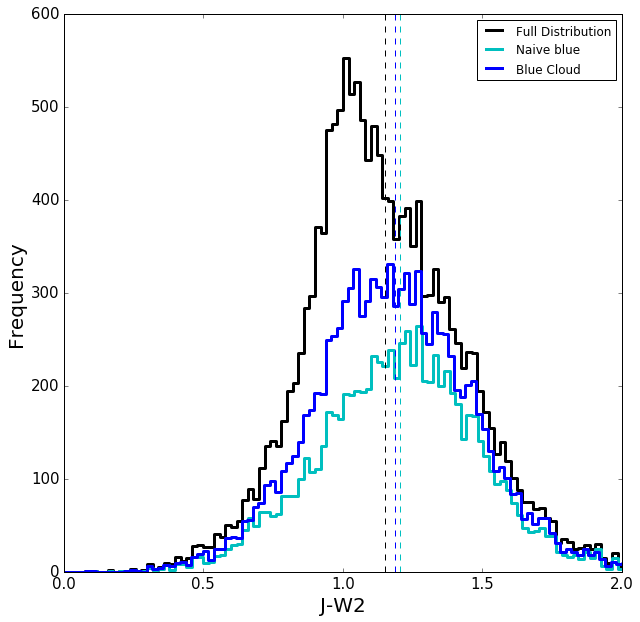

In [184]:
colrow = [9,13]


plt.figure(figsize=(10,10))
plot_hist([row[colrow[0]]-row[colrow[1]] for row in test_data],200,'Full Distribution',set_bin_size=True,bin_size=0.02,normed=False,colour='k')
plot_hist([row[colrow[0]]-row[colrow[1]] for row in naive_rb],200,'Naive blue',set_bin_size=True,bin_size=0.02,normed=False,colour='c')

#plot_hist([row[3]-row[5] for row in reduced_data],200,'Full Distribution',set_bin_size=True,bin_size=0.02,normed=False,colour='k')
plot_hist([row[colrow[0]]-row[colrow[1]] for row in reducedblue],200,'Blue Cloud',set_bin_size=True,bin_size=0.02,normed=False,colour='b')

label = names[colrow[0]-1]+'-'+names[colrow[1]-1]

full_mean = np.mean([row[colrow[0]]-row[colrow[1]] for row in test_data])
naive_mean = np.mean([row[colrow[0]]-row[colrow[1]] for row in naive_rb])
blue_mean = np.mean([row[colrow[0]]-row[colrow[1]] for row in reducedblue])
plt.plot([full_mean,full_mean],[0,600],'k--')
plt.plot([naive_mean,naive_mean],[0,600],'c--')
plt.plot([blue_mean,blue_mean],[0,600],'b--')


plt.xlim(0.,2.)
plt.xlabel(label,fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.legend()

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
np.mean([row[colrow[0]]-row[colrow[1]] for row in test_data]),np.mean([row[colrow[0]]-row[colrow[1]] for row in naive_rb]),np.mean([row[colrow[0]]-row[colrow[1]] for row in reducedblue])

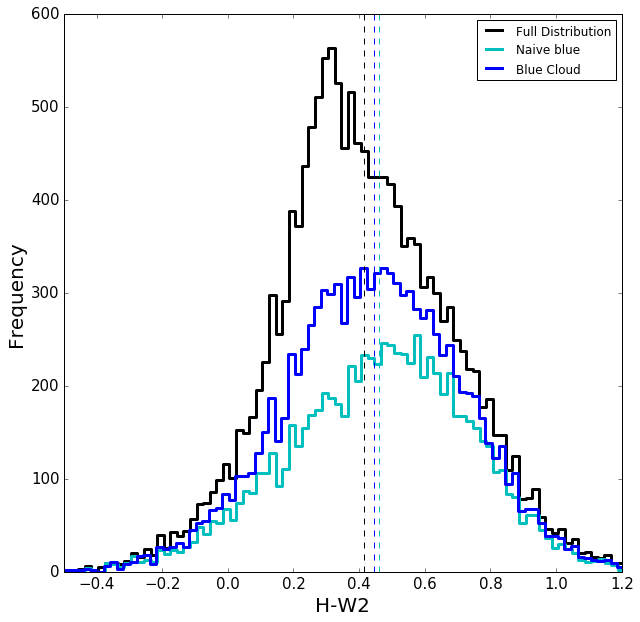

In [183]:
colrow = [10,13]


plt.figure(figsize=(10,10))
plot_hist([row[colrow[0]]-row[colrow[1]] for row in test_data],200,'Full Distribution',set_bin_size=True,bin_size=0.02,normed=False,colour='k')
plot_hist([row[colrow[0]]-row[colrow[1]] for row in naive_rb],200,'Naive blue',set_bin_size=True,bin_size=0.02,normed=False,colour='c')
plot_hist([row[colrow[0]]-row[colrow[1]] for row in reducedblue],200,'Blue Cloud',set_bin_size=True,bin_size=0.02,normed=False,colour='b')

label = names[colrow[0]-1]+'-'+names[colrow[1]-1]


plt.plot()
plt.xlim(-0.5,1.2)
# plot means
full_mean = np.mean([row[colrow[0]]-row[colrow[1]] for row in test_data])
naive_mean = np.mean([row[colrow[0]]-row[colrow[1]] for row in naive_rb])
blue_mean = np.mean([row[colrow[0]]-row[colrow[1]] for row in reducedblue])
plt.plot([full_mean,full_mean],[0,600],'k--')
plt.plot([naive_mean,naive_mean],[0,600],'c--')
plt.plot([blue_mean,blue_mean],[0,600],'b--')


plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel(label,fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.legend()

(0.16393344988006386, 0.23465407836318583, 0.19935389335358675)

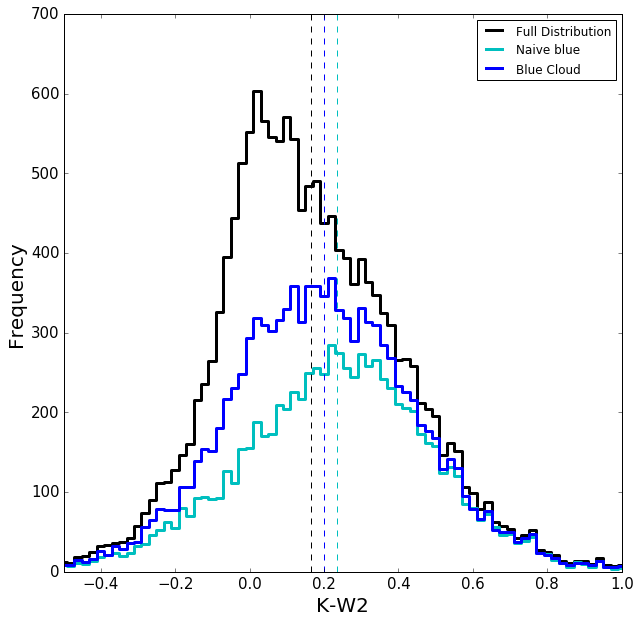

In [182]:
colrow = [11,13]


plt.figure(figsize=(10,10))
plot_hist([row[colrow[0]]-row[colrow[1]] for row in test_data],200,'Full Distribution',set_bin_size=True,bin_size=0.02,normed=False,colour='k')
plot_hist([row[colrow[0]]-row[colrow[1]] for row in naive_rb],200,'Naive blue',set_bin_size=True,bin_size=0.02,normed=False,colour='c')
plot_hist([row[colrow[0]]-row[colrow[1]] for row in reducedblue],200,'Blue Cloud',set_bin_size=True,bin_size=0.02,normed=False,colour='b')

label = names[colrow[0]-1]+'-'+names[colrow[1]-1]

full_mean = np.mean([row[colrow[0]]-row[colrow[1]] for row in test_data])
naive_mean = np.mean([row[colrow[0]]-row[colrow[1]] for row in naive_rb])
blue_mean = np.mean([row[colrow[0]]-row[colrow[1]] for row in reducedblue])
plt.plot([full_mean,full_mean],[0,700],'k--')
plt.plot([naive_mean,naive_mean],[0,700],'c--')
plt.plot([blue_mean,blue_mean],[0,700],'b--')


plt.xlim(-0.5,1.)
plt.xlabel(label,fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.legend()

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

np.mean([row[colrow[0]]-row[colrow[1]] for row in test_data]),np.mean([row[colrow[0]]-row[colrow[1]] for row in naive_rb]),np.mean([row[colrow[0]]-row[colrow[1]] for row in reducedblue])

(0.14283859314160782, 0.1748996443218655, 0.16217525746751027)

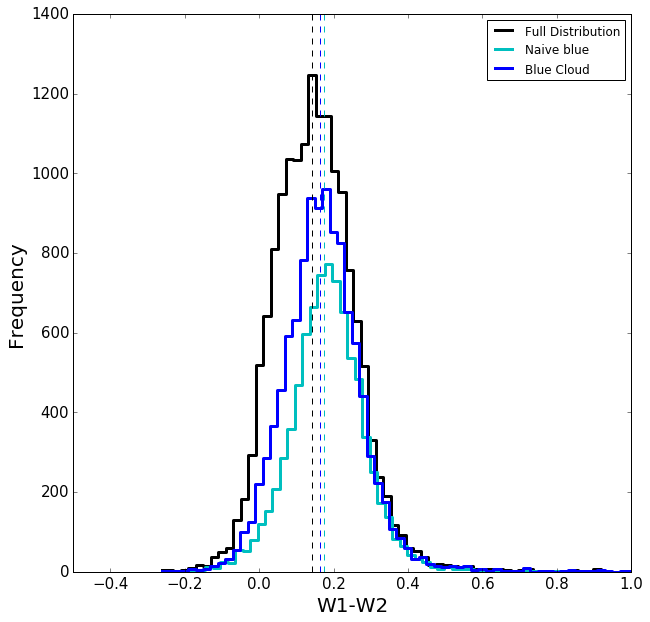

In [181]:
colrow = [12,13]


plt.figure(figsize=(10,10))
plot_hist([row[colrow[0]]-row[colrow[1]] for row in test_data],200,'Full Distribution',set_bin_size=True,bin_size=0.02,normed=False,colour='k')
plot_hist([row[colrow[0]]-row[colrow[1]] for row in naive_rb],200,'Naive blue',set_bin_size=True,bin_size=0.02,normed=False,colour='c')
plot_hist([row[colrow[0]]-row[colrow[1]] for row in reducedblue],200,'Blue Cloud',set_bin_size=True,bin_size=0.02,normed=False,colour='b')

label = names[colrow[0]-1]+'-'+names[colrow[1]-1]

full_mean = np.mean([row[colrow[0]]-row[colrow[1]] for row in test_data])
naive_mean = np.mean([row[colrow[0]]-row[colrow[1]] for row in naive_rb])
blue_mean = np.mean([row[colrow[0]]-row[colrow[1]] for row in reducedblue])
plt.plot([full_mean,full_mean],[0,1400],'k--')
plt.plot([naive_mean,naive_mean],[0,1400],'c--')
plt.plot([blue_mean,blue_mean],[0,1400],'b--')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


plt.xlim(-0.5,1.)
plt.xlabel(label,fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.legend()

np.mean([row[colrow[0]]-row[colrow[1]] for row in test_data]),np.mean([row[colrow[0]]-row[colrow[1]] for row in naive_rb]),np.mean([row[colrow[0]]-row[colrow[1]] for row in reducedblue])

(0.14283859314160782, 0.1748996443218655, 0.16217525746751027)

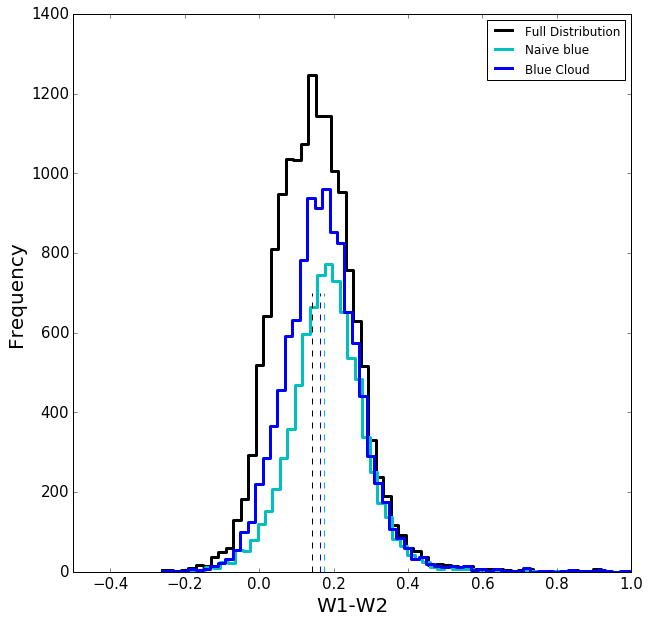

In [191]:
colrow = [12,13]


plt.figure(figsize=(10,10))
plot_hist([row[colrow[0]]-row[colrow[1]] for row in test_data],200,'Full Distribution',set_bin_size=True,bin_size=0.02,normed=False,colour='k')
plot_hist([row[colrow[0]]-row[colrow[1]] for row in naive_rb],200,'Naive blue',set_bin_size=True,bin_size=0.02,normed=False,colour='c')
plot_hist([row[colrow[0]]-row[colrow[1]] for row in reducedblue],200,'Blue Cloud',set_bin_size=True,bin_size=0.02,normed=False,colour='b')

label = names[colrow[0]-1]+'-'+names[colrow[1]-1]

full_mean = np.mean([row[colrow[0]]-row[colrow[1]] for row in test_data])
naive_mean = np.mean([row[colrow[0]]-row[colrow[1]] for row in naive_rb])
blue_mean = np.mean([row[colrow[0]]-row[colrow[1]] for row in reducedblue])
plt.plot([full_mean,full_mean],[0,700],'k--')
plt.plot([naive_mean,naive_mean],[0,700],'c--')
plt.plot([blue_mean,blue_mean],[0,700],'b--')


plt.xlim(-0.5,1.)
plt.xlabel(label,fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.legend()

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

np.mean([row[colrow[0]]-row[colrow[1]] for row in test_data]),np.mean([row[colrow[0]]-row[colrow[1]] for row in naive_rb]),np.mean([row[colrow[0]]-row[colrow[1]] for row in reducedblue])